In [1]:
import shapefile
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import geopandas as gpd
import descartes
from shapely.geometry import shape, Polygon, Point
from shapely.strtree import STRtree
from shapely.ops import nearest_points
from shapely import wkt
from ast import literal_eval
import requests
import json
import codecs
import osm2geojson
import time
import math

# Import 2014 Master Plan Land Use Data (https://data.gov.sg/dataset/master-plan-2014-land-use)

In [2]:
master_plan = gpd.read_file('MP2014/G_MP14_LAND_USE_PL.shp')

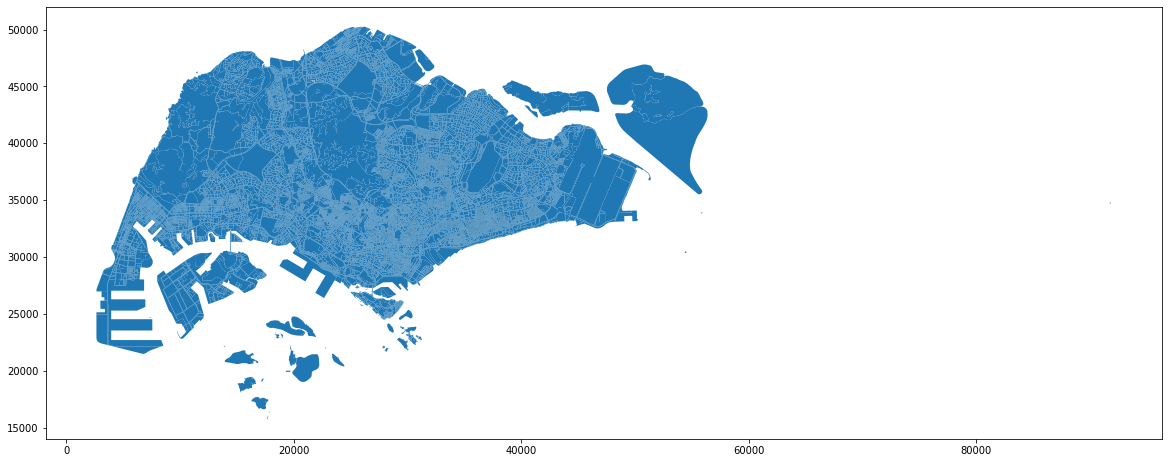

In [3]:
master_plan.plot(figsize=(20,20))

In [4]:
master_plan.head()

OBJECTID  OID_1     LU_DESC LU_TEXT   GPR  WHI_Q_MX  GPR_B_MN  \
0         1      0     UTILITY       U   EVA       0.0       0.0   
1         2      0  OPEN SPACE    None   EVA       0.0       0.0   
2         3      0  OPEN SPACE    None   EVA       0.0       0.0   
3         4      0  OPEN SPACE    None   EVA       0.0       0.0   
4         5      0        ROAD    None  None       0.0       0.0   

            INC_CRC  FMEL_UPD_D      X_ADDR      Y_ADDR   SHAPE_Leng  \
0  BF0C37311F485B64  2014-06-23  23226.8650  37189.3295  1474.502127   
1  DD6E9ED08FF9F421  2014-06-23  24627.6556  36234.1907   813.738237   
2  9A88CBC8A00238DF  2014-06-23  28064.7767  35926.0034   771.441679   
3  2481817E30624F97  2014-06-23  26176.9607  35947.5340  1686.764546   
4  C56C3E0EF8A3E0CF  2014-06-23  28179.4427  35988.4606   192.493764   

      SHAPE_Area                                           geometry  
0   70314.109927  POLYGON ((23311.893 37295.503, 23321.050 37278...  
1   37851.220985  POLYGON ((24653.610 36352.795, 24724.302 36291...  
2   12284.431868  POLYGON ((28204.673 35972.492, 28204.150 35972...  
3  151032.767607  POLYGON ((26136.730 35673.236, 26138.818 35678...  
4    1162.365423  POLYGON ((28224.064 35984.721, 28204.673 35972...

master_plan is based on the EPSG 3414 coordinate reference system (CRS) and therefore should be converted to EPSG 4326 (based on the lat/lon) to work nicely with OSM data.

In [5]:
master_plan.crs = {'init':'epsg:3414'}
master_plan = master_plan.to_crs('EPSG:4326')

C:\Anaconda3\envs\geo\lib\site-packages\pyproj\crs\crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


# Import planning area data (https://app.swaggerhub.com/apis/onemap-sg/new-onemap-api/1.0.2) - currently not in use

In [6]:
with open('Planning areas/planning_area.json') as f:
    data = json.load(f)

The following script is used to find the boundaries of a certain planning area, e.g. Queenstown

In [7]:
area_to_be_found = 'QUEENSTOWN'
n = 0
for item in data:
    if item['pln_area_n'] == area_to_be_found:
        break
    n += 1

Extract the information contained in the json file for the corresponding area and store it in a GeoSeries

In [8]:
planning_area = gpd.GeoSeries(shape(literal_eval(data[n]['geojson'])))

In [9]:
planning_area

0    MULTIPOLYGON (((103.80228 1.30724, 103.80243 1...
dtype: geometry

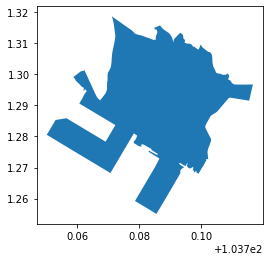

In [10]:
planning_area.plot()

In [11]:
planning_areas = gpd.GeoDataFrame(np.nan, range(0, len(data)), ['planning_area_name', 'geometry'])
planning_areas.crs = {'init':'epsg:4326'}

C:\Anaconda3\envs\geo\lib\site-packages\pyproj\crs\crs.py:55: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [12]:
def retrieve_geometry_from(geojson):
    try:
        return gpd.GeoSeries(shape(literal_eval(geojson))).values
    except ValueError:
        return None

In [13]:
for index in planning_areas.index:
    planning_areas.loc[index, 'planning_area_name'] = data[index]['pln_area_n']
    planning_areas.loc[index, 'geometry'] = retrieve_geometry_from(data[index]['geojson'])

In [14]:
planning_areas.dropna(inplace=True)

In [15]:
planning_areas

planning_area_name                                           geometry
0                   SIMPANG  MULTIPOLYGON (((103.85931 1.43906, 103.85956 1...
1          SOUTHERN ISLANDS  MULTIPOLYGON (((103.83525 1.21334, 103.83510 1...
2              SUNGEI KADUT  MULTIPOLYGON (((103.76628 1.44120, 103.76637 1...
3                      TUAS  MULTIPOLYGON (((103.64844 1.23980, 103.64855 1...
4           WESTERN ISLANDS  MULTIPOLYGON (((103.74128 1.16087, 103.74134 1...
5   WESTERN WATER CATCHMENT  MULTIPOLYGON (((103.66186 1.39820, 103.66191 1...
6             DOWNTOWN CORE  MULTIPOLYGON (((103.85942 1.29978, 103.85954 1...
7                    NEWTON  MULTIPOLYGON (((103.84432 1.31056, 103.84449 1...
8                   ORCHARD  MULTIPOLYGON (((103.84298 1.30001, 103.84294 1...
9                   KALLANG  MULTIPOLYGON (((103.86874 1.32782, 103.86884 1...
10             LIM CHU KANG  MULTIPOLYGON (((103.72169 1.45105, 103.72184 1...
11    NORTH-EASTERN ISLANDS  MULTIPOLYGON (((104.06991 1.34728, 104.06980 1...
12                PASIR RIS  MULTIPOLYGON (((103.97327 1.38734, 103.97381 1...
13             STRAITS VIEW  MULTIPOLYGON (((103.85205 1.26145, 103.85121 1...
14              MARINA EAST  MULTIPOLYGON (((103.86475 1.28885, 103.86474 1...
15             MARINA SOUTH  MULTIPOLYGON (((103.86230 1.28854, 103.86257 1...
16                   TENGAH  MULTIPOLYGON (((103.74849 1.36905, 103.74704 1...
17                SERANGOON  MULTIPOLYGON (((103.87311 1.38734, 103.87313 1...
19                 BOON LAY  MULTIPOLYGON (((103.71960 1.32359, 103.71961 1...
20                    BEDOK  MULTIPOLYGON (((103.96386 1.31396, 103.96371 1...
21              BUKIT MERAH  MULTIPOLYGON (((103.81252 1.26428, 103.81262 1...
22            BUKIT PANJANG  MULTIPOLYGON (((103.77445 1.39029, 103.77499 1...
23              JURONG EAST  MULTIPOLYGON (((103.71134 1.29959, 103.71192 1...
24              BUKIT TIMAH  MULTIPOLYGON (((103.81862 1.33579, 103.81827 1...
25  CENTRAL WATER CATCHMENT  MULTIPOLYGON (((103.80578 1.41436, 103.80594 1...
26                   CHANGI  MULTIPOLYGON (((103.97385 1.38686, 103.97381 1...
27            CHOA CHU KANG  MULTIPOLYGON (((103.75513 1.38887, 103.75523 1...
28               QUEENSTOWN  MULTIPOLYGON (((103.80228 1.30724, 103.80243 1...
29                  SELETAR  MULTIPOLYGON (((103.89741 1.41489, 103.89736 1...
30                   MANDAI  MULTIPOLYGON (((103.82588 1.43536, 103.82599 1...
31               ANG MO KIO  MULTIPOLYGON (((103.85811 1.39111, 103.85811 1...
32                   BISHAN  MULTIPOLYGON (((103.85686 1.35551, 103.85686 1...
33              BUKIT BATOK  MULTIPOLYGON (((103.77038 1.34902, 103.76842 1...
34               CHANGI BAY  MULTIPOLYGON (((104.02379 1.32493, 104.02462 1...
35              JURONG WEST  MULTIPOLYGON (((103.72814 1.35361, 103.72813 1...
36                 CLEMENTI  MULTIPOLYGON (((103.76461 1.33282, 103.76465 1...
37                  GEYLANG  MULTIPOLYGON (((103.90671 1.31332, 103.90658 1...
38                  HOUGANG  MULTIPOLYGON (((103.91005 1.37586, 103.91001 1...
39                  PIONEER  MULTIPOLYGON (((103.69651 1.32776, 103.69653 1...
40                  PUNGGOL  MULTIPOLYGON (((103.89799 1.41462, 103.89777 1...
41                SEMBAWANG  MULTIPOLYGON (((103.83669 1.44562, 103.83632 1...
42                 SENGKANG  MULTIPOLYGON (((103.88681 1.40121, 103.88682 1...
43                 TAMPINES  MULTIPOLYGON (((103.96429 1.35270, 103.96433 1...
44                  TANGLIN  MULTIPOLYGON (((103.83534 1.31737, 103.83498 1...
45                TOA PAYOH  MULTIPOLYGON (((103.86044 1.34340, 103.86086 1...
46                WOODLANDS  MULTIPOLYGON (((103.76953 1.44856, 103.76975 1...
47                   YISHUN  MULTIPOLYGON (((103.84626 1.43561, 103.84453 1...
48                   MUSEUM  MULTIPOLYGON (((103.84543 1.30136, 103.84563 1...
49                   OUTRAM  MULTIPOLYGON (((103.84718 1.28543, 103.84774 1...
50            MARINE PARADE  MULTIPOLYGON (((103.91956 1.30

# Import buildings data from OSM using the Overpass API

Send a query to the Overpass API to obtain the necessary information. Skip if database is already present locally.

In [ ]:
overpass_url = "http://overpass-api.de/api/interpreter"
# The below query is used to find ALL buildings in Singapore
overpass_query = """
[out:json];
area["ISO3166-1"="SG"][admin_level=2];
(way["building"](area);
 rel["building"]["type"="multipolygon"](area);
);
out;>;out qt;
"""
response = requests.get(overpass_url, 
                        params={'data': overpass_query})
data = response.json()

data contains the output from Overpass API in json format. It should be converted to geojson and eventually stored in a GeoDataFrame. The below approach converts data from json to geojson format and store it in buildings.geojson - this is a workaround to allow GeoPandas to properly read the information into a GeoPandas dataframe.

In [ ]:
gjs = osm2geojson.json2geojson(data)
with open('buildings.geojson','w') as f:
    json.dump(gjs, f)

The above errors are probably caused by inaccurate geometry information contained in the OSM database. It's probably safe to ignore them for the moment

In [16]:
buildings = gpd.read_file('buildings.geojson')

In [17]:
buildings.head()

type        id                                               tags  \
0  way  22875450  {'building': 'train_station', 'name': 'Bukit B...   
1  way  22886442  {'addr:city': 'Singapore', 'addr:country': 'SG...   
2  way  24680746            {'building': 'civic', 'sport': 'multi'}   
3  way  26561741  {'addr:city': 'Singapore', 'addr:country': 'SG...   
4  way  30527021  {'addr:city': 'Singapore', 'addr:country': 'SG...   

                                            geometry  
0  POLYGON ((103.74901 1.34852, 103.74912 1.34844...  
1  POLYGON ((103.70508 1.33839, 103.70516 1.33819...  
2  POLYGON ((103.88808 1.37098, 103.88803 1.37105...  
3  POLYGON ((103.99431 1.36489, 103.99427 1.36494...  
4  POLYGON ((103.85308 1.30254, 103.85302 1.30259...

Some useful information could be extracted from the tags, e.g.: building use in 'building' and number of floors in 'building:levels'. This could be done using apply and the below function to extract the required feature.

In [18]:
def extract_feature(row, feature):
    try:
        return row[feature]
    except:
        return None

In [19]:
buildings['use_OSM'] = buildings['tags'].apply(extract_feature, feature='building')
buildings['levels'] = buildings['tags'].apply(extract_feature, feature='building:levels')

In [20]:
buildings.head()

type        id                                               tags  \
0  way  22875450  {'building': 'train_station', 'name': 'Bukit B...   
1  way  22886442  {'addr:city': 'Singapore', 'addr:country': 'SG...   
2  way  24680746            {'building': 'civic', 'sport': 'multi'}   
3  way  26561741  {'addr:city': 'Singapore', 'addr:country': 'SG...   
4  way  30527021  {'addr:city': 'Singapore', 'addr:country': 'SG...   

                                            geometry        use_OSM levels  
0  POLYGON ((103.74901 1.34852, 103.74912 1.34844...  train_station   None  
1  POLYGON ((103.70508 1.33839, 103.70516 1.33819...  train_station   None  
2  POLYGON ((103.88808 1.37098, 103.88803 1.37105...          civic   None  
3  POLYGON ((103.99431 1.36489, 103.99427 1.36494...            yes      3  
4  POLYGON ((103.85308 1.30254, 103.85302 1.30259...         retail      6

# Match each building with its corresponding use according to the 2014 MP

Each building's centroid must be contained within one land use polygon stored in master_plan. The matching could be done with the geopandas' sjoin function, passing op='within' as an argument. 

In [21]:
# Create a copy of the buildings dataframe which has the centroids of the buildings in the geometry column instead of the
# original building polygons
buildings_copy = buildings.copy()
buildings_copy['geometry'] = buildings_copy.centroid

In [22]:
%time buildings_copy =  gpd.sjoin(buildings_copy, master_plan, op='within')

Wall time: 37.7 s


In [23]:
# Add planning area info to buildings
buildings_copy.drop(['index_right'], axis=1, inplace=True)
%time buildings_copy = gpd.sjoin(buildings_copy, planning_areas, op='within', how='left')

C:\Anaconda3\envs\geo\lib\site-packages\geopandas\tools\sjoin.py:61: UserWarning: CRS of frames being joined does not match!(epsg:4326 != +init=epsg:4326 +type=crs)
  "(%s != %s)" % (left_df.crs, right_df.crs)


Wall time: 9.78 s


In [24]:
# Duplicate indexes are present in buildings_copy, therefore we need to keep only the first entry and remove the rest
buildings_copy = buildings_copy[~buildings_copy['LU_DESC'].index.duplicated(keep='first')]

In [25]:
buildings['use_MP'] = buildings_copy['LU_DESC']
buildings['planning_area'] = buildings_copy['planning_area_name']

In [26]:
buildings.loc[buildings['planning_area'].isna(), 'planning_area'] = 'OTHER'

In [27]:
buildings

type         id                                               tags  \
0       way   22875450  {'building': 'train_station', 'name': 'Bukit B...   
1       way   22886442  {'addr:city': 'Singapore', 'addr:country': 'SG...   
2       way   24680746            {'building': 'civic', 'sport': 'multi'}   
3       way   26561741  {'addr:city': 'Singapore', 'addr:country': 'SG...   
4       way   30527021  {'addr:city': 'Singapore', 'addr:country': 'SG...   
...     ...        ...                                                ...   
103351  way  779029504                                {'building': 'yes'}   
103352  way  779510555                                {'building': 'yes'}   
103353  way  779511453                                {'building': 'yes'}   
103354  way  779511456                                {'building': 'yes'}   
103355  way  780050411  {'addr:city': 'Singapore', 'addr:country': 'SG...   

                                                 geometry        use_OSM  \
0       POLYGON ((103.74901 1.34852, 103.74912 1.34844...  train_station   
1       POLYGON ((103.70508 1.33839, 103.70516 1.33819...  train_station   
2       POLYGON ((103.88808 1.37098, 103.88803 1.37105...          civic   
3       POLYGON ((103.99431 1.36489, 103.99427 1.36494...            yes   
4       POLYGON ((103.85308 1.30254, 103.85302 1.30259...         retail   
...                                                   ...            ...   
103351  POLYGON ((103.82709 1.37019, 103.82712 1.37014...            yes   
103352  POLYGON ((103.80073 1.27267, 103.80063 1.27254...            yes   
103353  POLYGON ((103.80460 1.27850, 103.80441 1.27853...            yes   
103354  POLYGON ((103.80453 1.27650, 103.80451 1.27645...            yes   
103355  POLYGON ((103.81021 1.28101, 103.81051 1.28098...         garage   

       levels               use_MP            planning_area  
0        None   MASS RAPID TRANSIT              BUKIT BATOK  
1        None   MASS RAPID TRANSIT              JURONG WEST  
2        None  SPORTS & RECREATION                  HOUGANG  
3           3       PORT / AIRPORT                   CHANGI  
4           6           COMMERCIAL                   ROCHOR  
...       ...                  ...                      ...  
103351   None           OPEN SPACE  CENTRAL WATER CATCHMENT  
103352   None              UTILITY               QUEENSTOWN  
103353   None         RESERVE SITE              BUKIT MERAH  
103354   None         RESERVE SITE              BUKIT MERAH  
103355      6           COMMERCIAL              BUKIT MERAH  

[103356 rows x 8 columns]

# Import preprocessed data from HDB and commercial buildings preprocessing

In [28]:
hdb_commercial = pd.read_csv('hdb_commercial.csv', index_col=0)

In [29]:
# Convert 'grossfloorarea' to int
hdb_commercial.loc[:,'grossfloorarea'] = hdb_commercial['grossfloorarea'].str.replace(',', '').fillna(0).astype(int)

In [30]:
# Identify HDB buildings by assigning 'Residential' to 'buildingtype'
hdb_commercial.loc[hdb_commercial['buildingtype'].isna(), 'buildingtype'] = 'Residential'

# Merge both dataframes

In [31]:
buildings = buildings.merge(hdb_commercial, how='left', on='id')

# Summarize building use and levels

In [32]:
buildings

type         id                                               tags  \
0       way   22875450  {'building': 'train_station', 'name': 'Bukit B...   
1       way   22886442  {'addr:city': 'Singapore', 'addr:country': 'SG...   
2       way   24680746            {'building': 'civic', 'sport': 'multi'}   
3       way   26561741  {'addr:city': 'Singapore', 'addr:country': 'SG...   
4       way   30527021  {'addr:city': 'Singapore', 'addr:country': 'SG...   
...     ...        ...                                                ...   
103933  way  779029504                                {'building': 'yes'}   
103934  way  779510555                                {'building': 'yes'}   
103935  way  779511453                                {'building': 'yes'}   
103936  way  779511456                                {'building': 'yes'}   
103937  way  780050411  {'addr:city': 'Singapore', 'addr:country': 'SG...   

                                                 geometry        use_OSM  \
0       POLYGON ((103.74901 1.34852, 103.74912 1.34844...  train_station   
1       POLYGON ((103.70508 1.33839, 103.70516 1.33819...  train_station   
2       POLYGON ((103.88808 1.37098, 103.88803 1.37105...          civic   
3       POLYGON ((103.99431 1.36489, 103.99427 1.36494...            yes   
4       POLYGON ((103.85308 1.30254, 103.85302 1.30259...         retail   
...                                                   ...            ...   
103933  POLYGON ((103.82709 1.37019, 103.82712 1.37014...            yes   
103934  POLYGON ((103.80073 1.27267, 103.80063 1.27254...            yes   
103935  POLYGON ((103.80460 1.27850, 103.80441 1.27853...            yes   
103936  POLYGON ((103.80453 1.27650, 103.80451 1.27645...            yes   
103937  POLYGON ((103.81021 1.28101, 103.81051 1.28098...         garage   

       levels               use_MP            planning_area buildingname  \
0        None   MASS RAPID TRANSIT              BUKIT BATOK          NaN   
1        None   MASS RAPID TRANSIT              JURONG WEST          NaN   
2        None  SPORTS & RECREATION                  HOUGANG          NaN   
3           3       PORT / AIRPORT                   CHANGI          NaN   
4           6           COMMERCIAL                   ROCHOR          NaN   
...       ...                  ...                      ...          ...   
103933   None           OPEN SPACE  CENTRAL WATER CATCHMENT          NaN   
103934   None              UTILITY               QUEENSTOWN          NaN   
103935   None         RESERVE SITE              BUKIT MERAH          NaN   
103936   None         RESERVE SITE              BUKIT MERAH          NaN   
103937      6           COMMERCIAL              BUKIT MERAH          NaN   

       buildingtype greenmarkrating  grossfloorarea  max_floor_lvl  \
0               NaN             NaN             NaN            NaN   
1               NaN             NaN             NaN            NaN   
2               NaN             NaN             NaN            NaN   
3               NaN             NaN             NaN            NaN   
4               NaN             NaN             NaN            NaN   
...             ...             ...             ...            ...   
103933          NaN             NaN             NaN            NaN   
103934          NaN             NaN             NaN            NaN   
103935          NaN             NaN             NaN            NaN   
103936          NaN             NaN             NaN            NaN   
103937          NaN             NaN             NaN            NaN   

        year_completed  
0                  NaN  
1                  NaN  
2                  NaN  
3                  NaN  
4                  NaN  
...                ...  
103933             NaN  
103934             NaN  
103935             NaN  
103936             NaN  
103937             NaN  

[103938 rows x 14 columns]

Priority: use from hdb_commercial ('buildingtype') > 'use_MP' > 'use_OSM'
Argumentation: use according to hdb_commercial should be the most trustworthy since the original data refers to individual buildings and not areas

In [33]:
buildings['use'] = buildings['buildingtype'].copy()
buildings.loc[buildings['use'].isna(), 'use'] = buildings.loc[buildings['use'].isna(), 'use_MP']
buildings.loc[buildings['use'].isna(), 'use'] = buildings.loc[buildings['use'].isna(), 'use_OSM']

The building use should eventually be narrowed down into the following categories:
* single_res
* multi_res
* university
* school
* retail
* office
* hotel
* hospital
* industrial
* other

In [34]:
buildings['use'] = buildings['use'].str.lower()

In [35]:
buildings['use'].value_counts()

residential                                     70096
business 2                                       9790
commercial                                       4827
special use                                      2058
educational institution                          1957
reserve site                                     1665
business 1                                       1470
residential with commercial at 1st storey        1313
civic & community institution                    1053
utility                                          1039
agriculture                                       933
sports & recreation                               770
open space                                        761
commercial & residential                          739
place of worship                                  738
residential / institution                         692
park                                              656
hotel                                             559
road                        

In [36]:
use_mapping = {
    'residential':'multi_res',
    'business 2':'industrial',
    'commercial':'retail',
    'special use':'other',
    'educational institution':'school',
    'reserve site':'other',
    'business 1':'industrial',
    'residential with commercial at 1st storey':'multi_res+retail',
    'civic & community institution':'other',
    'utility':'other',
    'agriculture':'other',
    'sports & recreation':'other',
    'open space':'other',
    'commercial & residential':'multi_res+retail',
    'place of worship':'other',
    'residential / institution':'multi_res+other',
    'park':'other',
    'hotel':'hotel',
    'road':'other',
    'office':'office',
    'transport facilities':'other',
    'white':'office+retail',
    'port / airport':'other',
    'health & medical care':'hospital',
    'retail':'retail',
    'business park':'office',
    'mass rapid transit':'other',
    'mixed development':'office+retail',
    'yes':'other',
    'cemetery':'other',
    'business 1 - white':'industrial+retail',
    'business park - white':'office+retail',
    'waterbody':'other',
    'nursing home':'other',
    'univerisity':'university',
    'private school':'school',
    'light rapid transit':'other',
    'beach area':'other',
    'polyclinic':'hospital',
    'business 2 - white':'industrial+retail',
    'private clinic':'hospital',
    'polytechnic':'university',
    'general hospital/ specialist centre (public)':'hospital',
    'private college':'university',
    'private hospital (private)':'hospital',
    'ite':'university',
    'specialist centre (public)':'hospital',
    'community hospital':'hospital',
    'roof':'other',
    'hut':'other',
    'house':'other',
    'tcm clinic':'hospital'
}

In [37]:
buildings['use'] = buildings['use'].map(use_mapping)

In [38]:
buildings['use'].value_counts()

multi_res            70096
industrial           11260
other                11074
retail                4960
multi_res+retail      2052
school                1974
multi_res+other        692
hotel                  559
office                 517
office+retail          448
hospital               240
industrial+retail       37
university              29
Name: use, dtype: int64

In [39]:
buildings.fillna(value=np.nan, inplace=True)

In [40]:
buildings['no_storeys'] = buildings['max_floor_lvl']
# buildings.loc[buildings['no_storeys'].isna(), 'no_storeys'] = buildings['levels'].astype(float) 
# refrain from using this data atm

In [41]:
buildings.loc[(buildings['no_storeys']<=3) & (buildings['use']=='multi_res'), 'use'] = 'single_res'

In [42]:
buildings['use'].value_counts()

multi_res            69069
industrial           11260
other                11074
retail                4960
multi_res+retail      2052
school                1974
single_res            1027
multi_res+other        692
hotel                  559
office                 517
office+retail          448
hospital               240
industrial+retail       37
university              29
Name: use, dtype: int64

# Further exploratory data analysis

In [43]:
buildings['land_area'] = buildings.to_crs('epsg:3414').area
buildings['perimeter'] = buildings.to_crs('epsg:3414').length

In [44]:
buildings.groupby('use')['land_area'].mean()

use
hospital             2109.212968
hotel                1235.290857
industrial           2048.028018
industrial+retail    5330.086293
multi_res             504.704843
multi_res+other       274.660031
multi_res+retail      599.212299
office               2886.752926
office+retail        1504.255740
other                1182.045194
retail                462.737368
school               1446.865346
single_res           1345.382901
university           3987.222092
Name: land_area, dtype: float64

In [45]:
buildings['planning_area'].unique()

array(['BUKIT BATOK', 'JURONG WEST', 'HOUGANG', 'CHANGI', 'ROCHOR',
       'ANG MO KIO', 'MUSEUM', 'BUKIT MERAH', 'SOUTHERN ISLANDS',
       'SENGKANG', 'SELETAR', 'PIONEER', 'JURONG EAST', 'GEYLANG',
       'PASIR RIS', 'TAMPINES', 'BEDOK', 'PUNGGOL', 'SERANGOON',
       'QUEENSTOWN', 'TOA PAYOH', 'DOWNTOWN CORE', 'NEWTON', 'KALLANG',
       'ORCHARD', 'TANGLIN', 'BUKIT TIMAH', 'MARINE PARADE', 'WOODLANDS',
       'OUTRAM', 'SINGAPORE RIVER', 'BUKIT PANJANG', 'CLEMENTI',
       'BOON LAY', 'SEMBAWANG', 'WESTERN WATER CATCHMENT',
       'CENTRAL WATER CATCHMENT', 'NORTH-EASTERN ISLANDS', 'BISHAN',
       'LIM CHU KANG', 'TUAS', 'SUNGEI KADUT', 'YISHUN', 'OTHER',
       'PAYA LEBAR', 'CHANGI BAY', 'MANDAI', 'WESTERN ISLANDS', 'NOVENA',
       'CHOA CHU KANG', 'STRAITS VIEW', 'RIVER VALLEY', 'SIMPANG',
       'MARINA SOUTH', 'MARINA EAST', 'TENGAH'], dtype=object)

C:\Anaconda3\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


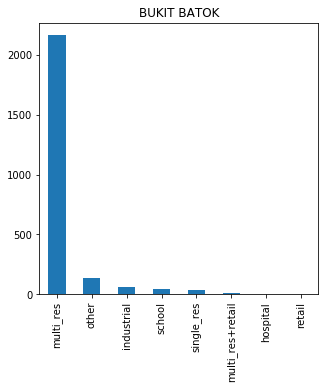

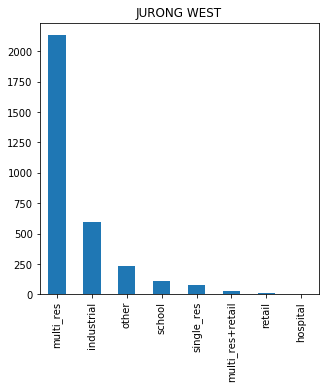

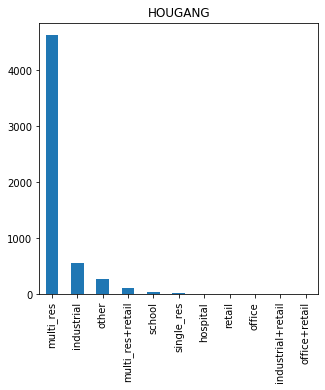

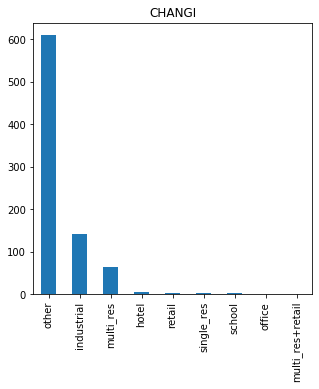

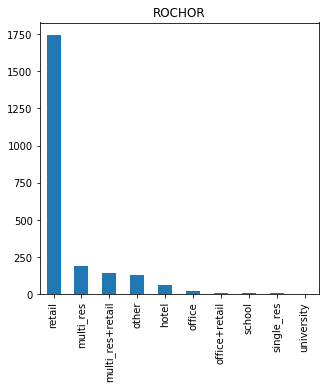

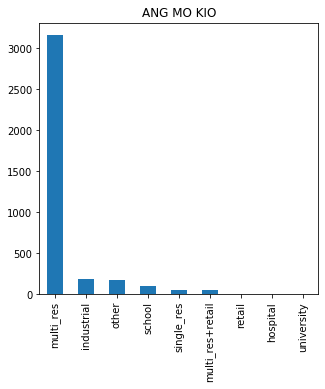

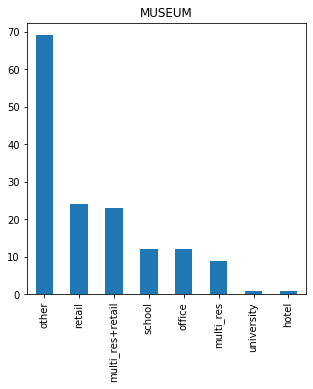

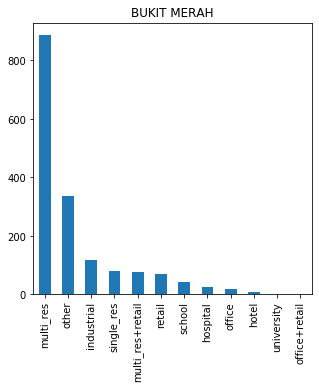

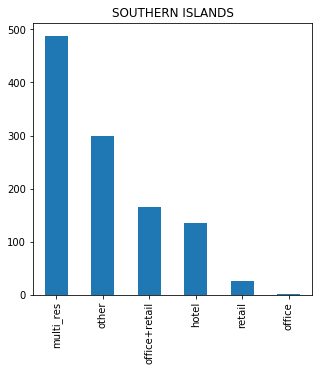

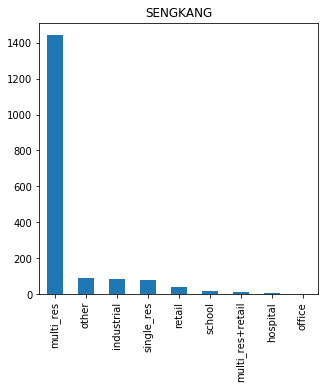

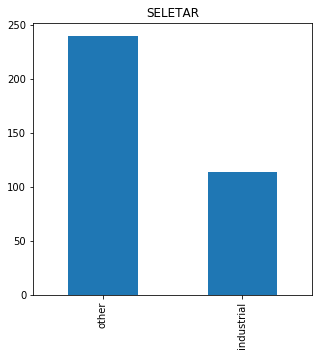

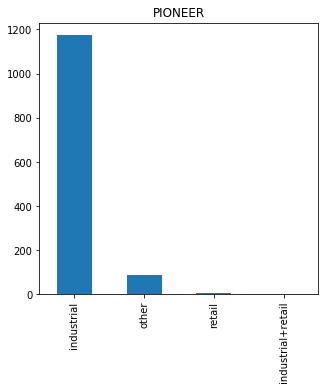

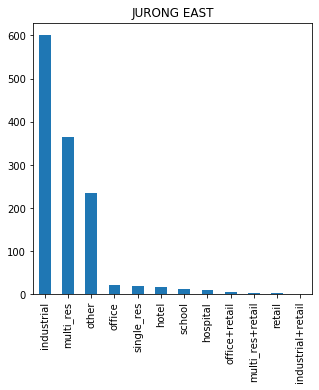

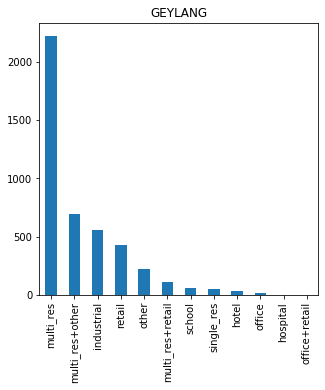

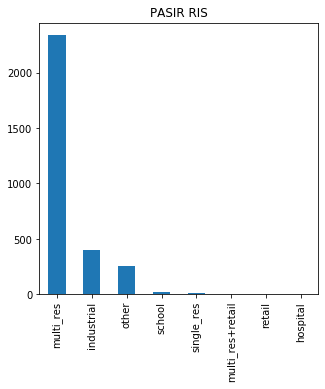

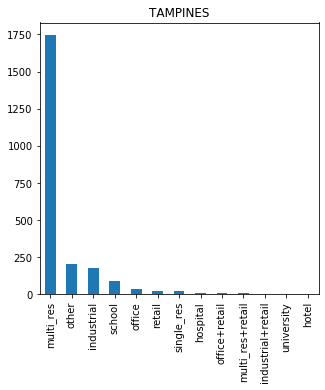

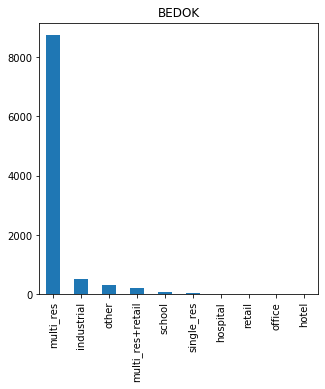

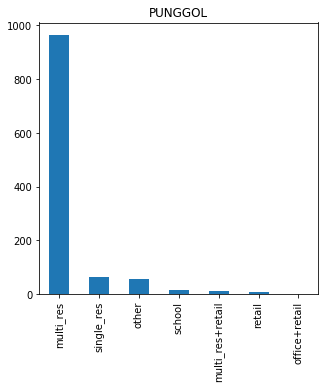

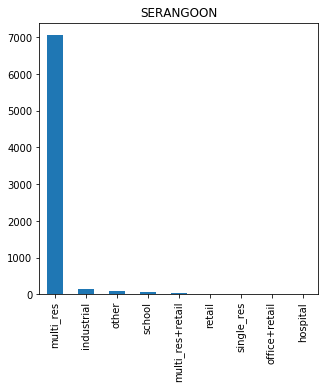

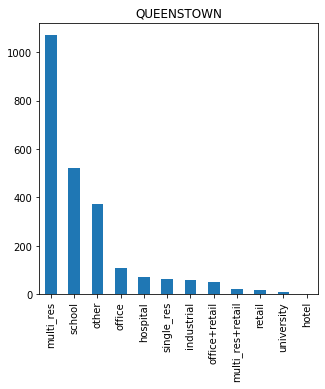

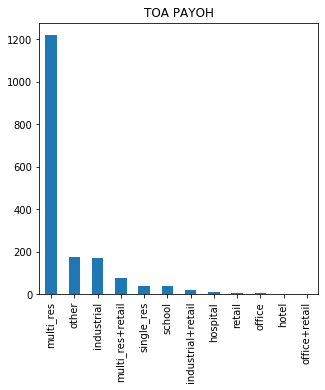

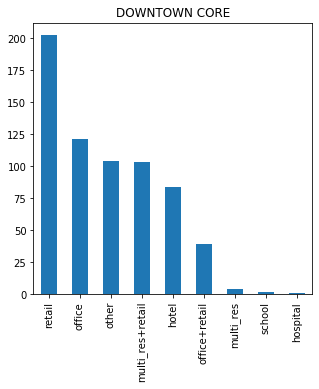

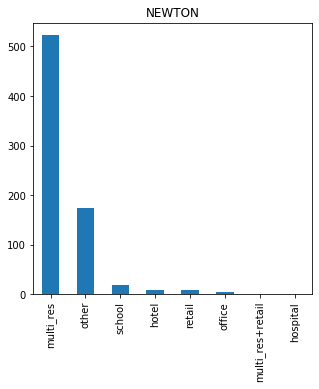

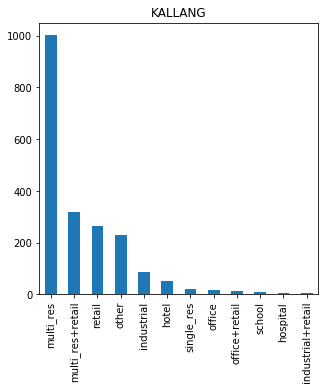

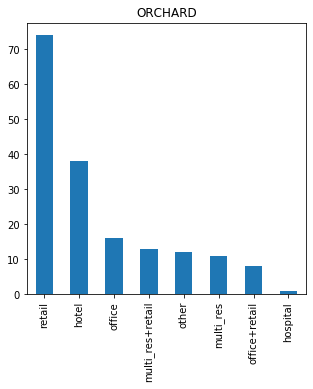

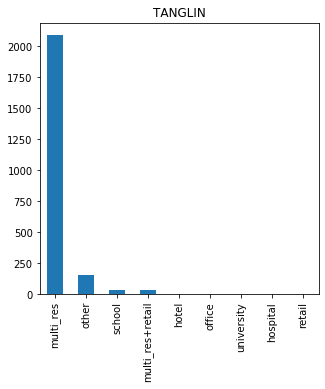

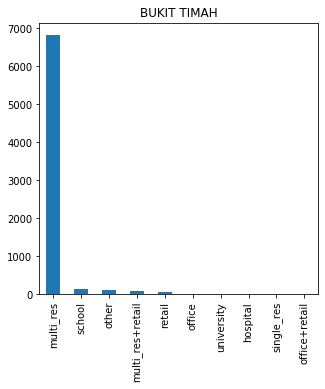

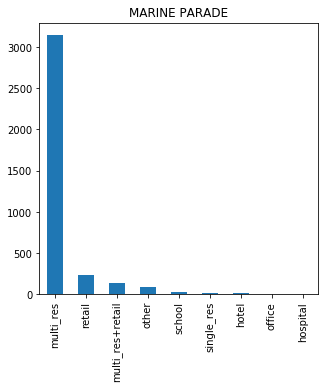

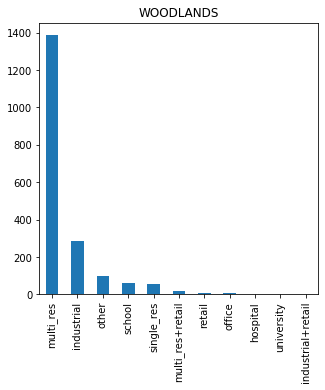

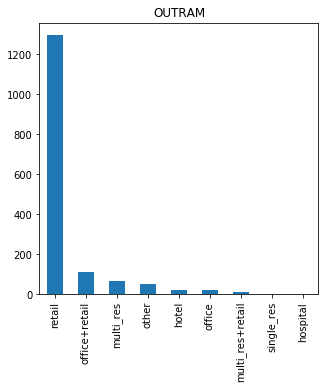

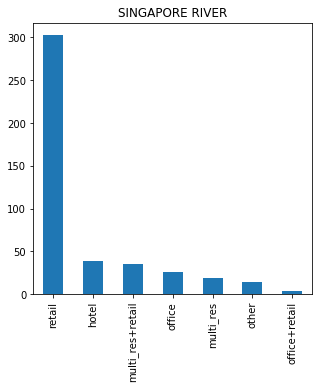

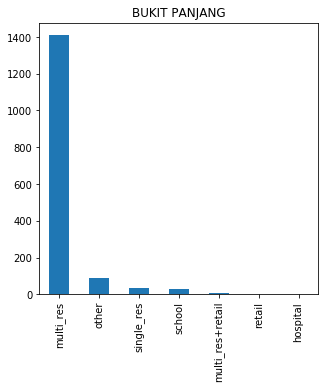

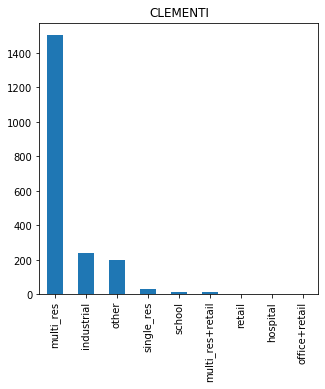

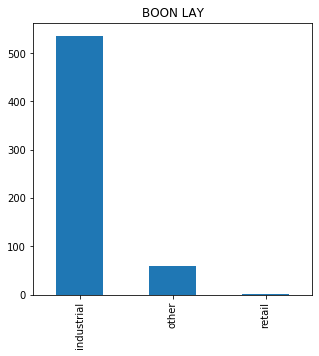

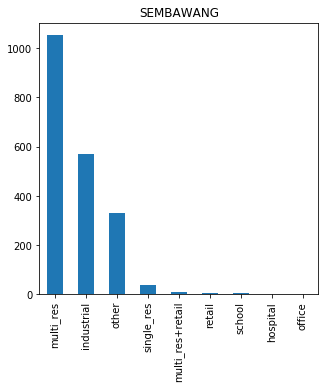

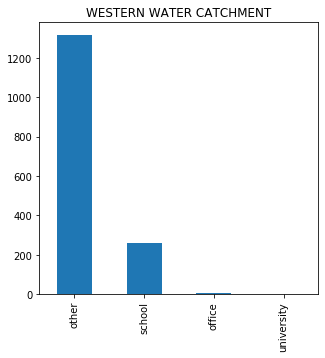

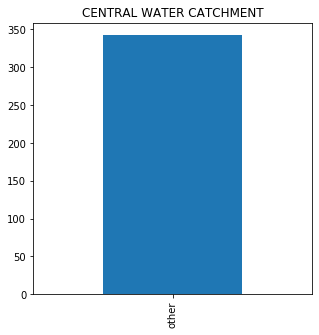

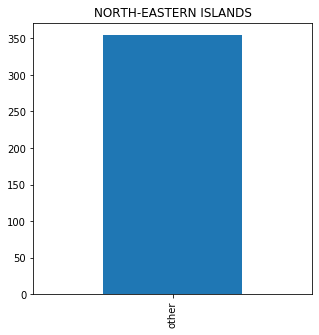

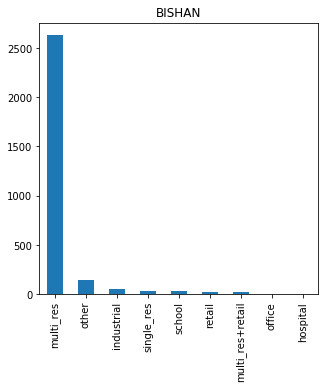

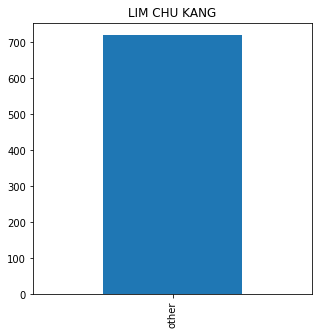

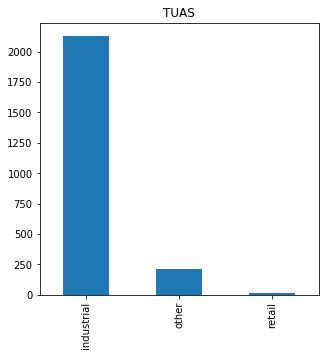

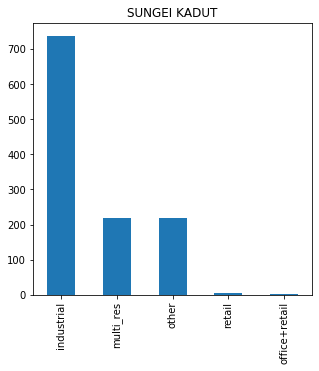

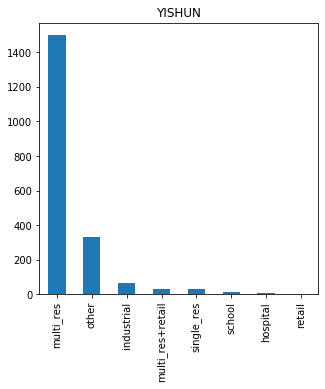

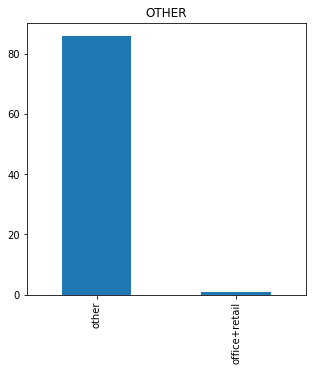

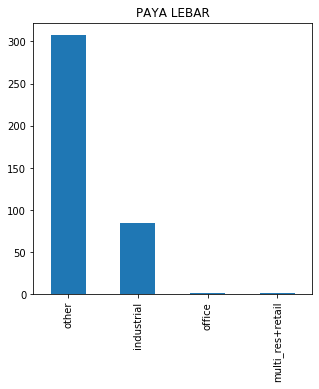

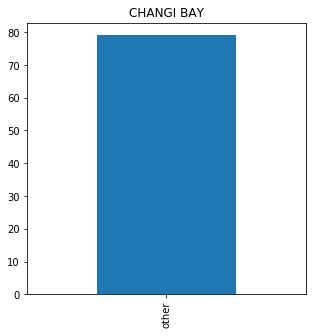

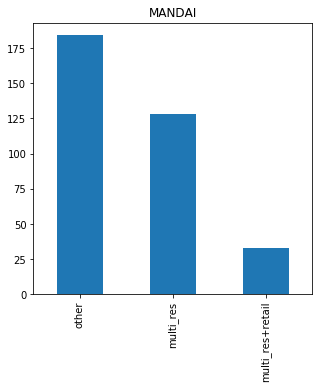

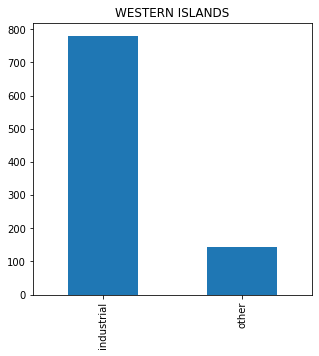

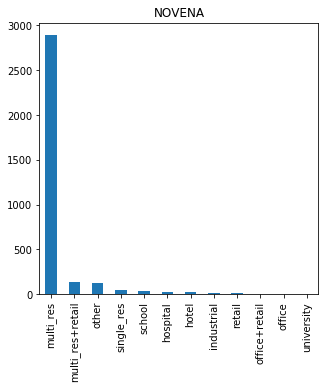

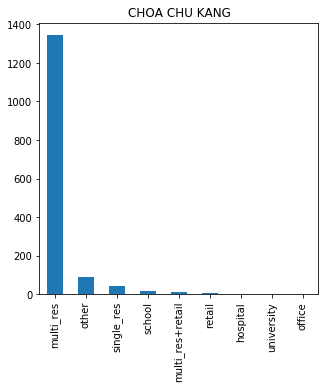

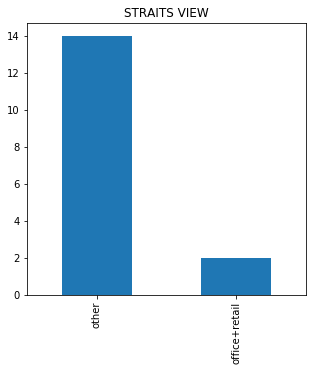

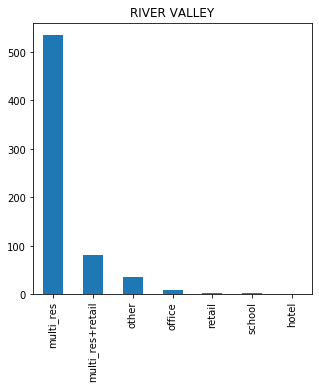

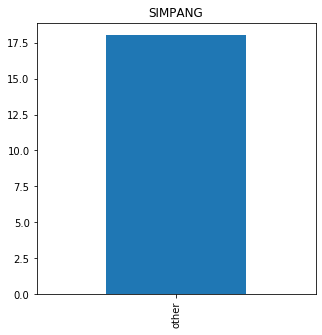

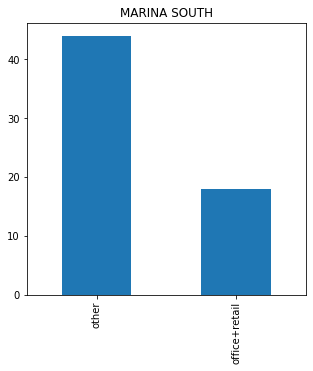

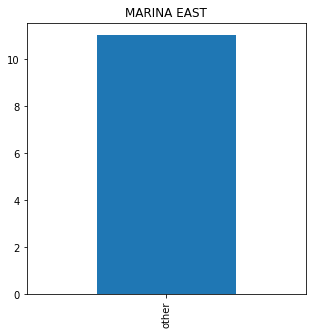

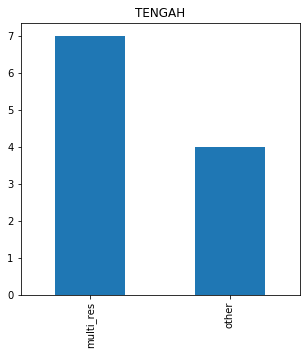

In [46]:
for area in buildings['planning_area'].unique():
    fig, ax = plt.subplots(figsize=(5,5))
    buildings[buildings['planning_area'] == area]['use'].value_counts().plot.bar(ax=ax, title=area)

# Derive building side lengths from area and perimeter information

In [ ]:
def calculate_sides_of_a_rectangle_with(area, perimeter):
    a = 1
    b = -perimeter/2
    c = area
    D = b**2-4*a*c
    try:
        # rectangular approximation
        x1 = (-b+math.sqrt(D))/2
        x2 = area/x1
    except:
        # parallelogram approximation
        x2 = math.sqrt(area*math.sqrt(2))
        x1 = perimeter/2-x2
    return x1, x2

In [ ]:
(buildings['side_1'], buildings['side_2']) = (buildings.apply(lambda x: calculate_sides_of_a_rectangle_with(x['land_area'], x['perimeter'])[0], axis=1), 
                                              buildings.apply(lambda x: calculate_sides_of_a_rectangle_with(x['land_area'], x['perimeter'])[1], axis=1))

In [ ]:
buildings

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
planning_areas.boundary.plot(color=None, edgecolor='k',linewidth = 1, ax=ax)
buildings.plot(column='use', ax=ax, legend=True)

ax.set_xlim(103.5, 104.2)

In [ ]:
planning_areas['geometry'][0].bounds

In [ ]:
for area in planning_areas['planning_area_name'].unique():
    fig, ax = plt.subplots(figsize=(10,10))
    planning_area = planning_areas[planning_areas['planning_area_name'] == area]
    planning_area.boundary.plot(color=None, edgecolor='k',linewidth = 1, ax=ax)
    buildings[buildings['planning_area'] == area].plot(column='use', ax=ax, legend=True)
    
    ax.set_title(area)

In [ ]:
def calculate_sides_of_a_rectangle_with(area, perimeter):
    a = 1
    b = -perimeter/2
    c = area
    D = b**2-4*a*c
    try:
        # rectangular approximation
        x1 = (-b+math.sqrt(D))/2
        x2 = area/x1
    except:
        # parallelogram approximation
        x2 = math.sqrt(area*math.sqrt(2))
        x1 = perimeter/2-x2
    return x1, x2

In [ ]:
(buildings['side_1'], buildings['side_2']) = (buildings.apply(lambda x: calculate_sides_of_a_rectangle_with(x['land_area'], x['perimeter'])[0], axis=1), 
                                              buildings.apply(lambda x: calculate_sides_of_a_rectangle_with(x['land_area'], x['perimeter'])[1], axis=1))

In [ ]:
buildings

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
planning_areas.boundary.plot(color=None, edgecolor='k',linewidth = 1, ax=ax)
buildings.plot(column='use', ax=ax, legend=True)

ax.set_xlim(103.5, 104.2)

In [ ]:
planning_areas['geometry'][0].bounds

In [ ]:
for area in planning_areas['planning_area_name'].unique():
    fig, ax = plt.subplots(figsize=(10,10))
    planning_area = planning_areas[planning_areas['planning_area_name'] == area]
    planning_area.boundary.plot(color=None, edgecolor='k',linewidth = 1, ax=ax)
    buildings[buildings['planning_area'] == area].plot(column='use', ax=ax, legend=True)
    
    ax.set_title(area)

In [47]:
def calculate_sides_of_a_rectangle_with(area, perimeter):
    a = 1
    b = -perimeter/2
    c = area
    D = b**2-4*a*c
    try:
        # rectangular approximation
        x1 = (-b+math.sqrt(D))/2
        x2 = area/x1
    except:
        # parallelogram approximation
        x2 = math.sqrt(area*math.sqrt(2))
        x1 = perimeter/2-x2
    return x1, x2

In [48]:
(buildings['side_1'], buildings['side_2']) = (buildings.apply(lambda x: calculate_sides_of_a_rectangle_with(x['land_area'], x['perimeter'])[0], axis=1), 
                                              buildings.apply(lambda x: calculate_sides_of_a_rectangle_with(x['land_area'], x['perimeter'])[1], axis=1))

In [49]:
buildings

type         id                                               tags  \
0       way   22875450  {'building': 'train_station', 'name': 'Bukit B...   
1       way   22886442  {'addr:city': 'Singapore', 'addr:country': 'SG...   
2       way   24680746            {'building': 'civic', 'sport': 'multi'}   
3       way   26561741  {'addr:city': 'Singapore', 'addr:country': 'SG...   
4       way   30527021  {'addr:city': 'Singapore', 'addr:country': 'SG...   
...     ...        ...                                                ...   
103933  way  779029504                                {'building': 'yes'}   
103934  way  779510555                                {'building': 'yes'}   
103935  way  779511453                                {'building': 'yes'}   
103936  way  779511456                                {'building': 'yes'}   
103937  way  780050411  {'addr:city': 'Singapore', 'addr:country': 'SG...   

                                                 geometry        use_OSM  \
0       POLYGON ((103.74901 1.34852, 103.74912 1.34844...  train_station   
1       POLYGON ((103.70508 1.33839, 103.70516 1.33819...  train_station   
2       POLYGON ((103.88808 1.37098, 103.88803 1.37105...          civic   
3       POLYGON ((103.99431 1.36489, 103.99427 1.36494...            yes   
4       POLYGON ((103.85308 1.30254, 103.85302 1.30259...         retail   
...                                                   ...            ...   
103933  POLYGON ((103.82709 1.37019, 103.82712 1.37014...            yes   
103934  POLYGON ((103.80073 1.27267, 103.80063 1.27254...            yes   
103935  POLYGON ((103.80460 1.27850, 103.80441 1.27853...            yes   
103936  POLYGON ((103.80453 1.27650, 103.80451 1.27645...            yes   
103937  POLYGON ((103.81021 1.28101, 103.81051 1.28098...         garage   

       levels               use_MP            planning_area buildingname  \
0         NaN   MASS RAPID TRANSIT              BUKIT BATOK          NaN   
1         NaN   MASS RAPID TRANSIT              JURONG WEST          NaN   
2         NaN  SPORTS & RECREATION                  HOUGANG          NaN   
3           3       PORT / AIRPORT                   CHANGI          NaN   
4           6           COMMERCIAL                   ROCHOR          NaN   
...       ...                  ...                      ...          ...   
103933    NaN           OPEN SPACE  CENTRAL WATER CATCHMENT          NaN   
103934    NaN              UTILITY               QUEENSTOWN          NaN   
103935    NaN         RESERVE SITE              BUKIT MERAH          NaN   
103936    NaN         RESERVE SITE              BUKIT MERAH          NaN   
103937      6           COMMERCIAL              BUKIT MERAH          NaN   

       buildingtype greenmarkrating  grossfloorarea  max_floor_lvl  \
0               NaN             NaN             NaN            NaN   
1               NaN             NaN             NaN            NaN   
2               NaN             NaN             NaN            NaN   
3               NaN             NaN             NaN            NaN   
4               NaN             NaN             NaN            NaN   
...             ...             ...             ...            ...   
103933          NaN             NaN             NaN            NaN   
103934          NaN             NaN             NaN            NaN   
103935          NaN             NaN             NaN            NaN   
103936          NaN             NaN             NaN            NaN   
103937          NaN             NaN             NaN            NaN   

        year_completed     use  no_storeys      land_area    perimeter  \
0                  NaN   other         NaN    3063.233340   375.159504   
1                  NaN   other         NaN    5116.704806   405.940172   
2                  NaN   other         NaN    4326.005580   283.084566   
3                  NaN   other         NaN  120477.252839  4598.095451   
4                  NaN  retail         NaN   

(103.5, 104.2)

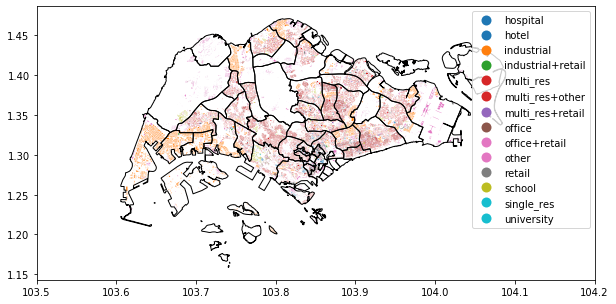

In [50]:
fig, ax = plt.subplots(figsize=(10,10))
planning_areas.boundary.plot(color=None, edgecolor='k',linewidth = 1, ax=ax)
buildings.plot(column='use', ax=ax, legend=True)

ax.set_xlim(103.5, 104.2)

In [56]:
planning_areas['geometry'][0].bounds

(103.833063944241, 1.42639598659012, 103.866165918039, 1.45863243166748)

C:\Anaconda3\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\Anaconda3\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\Anaconda3\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_war

C:\Anaconda3\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\Anaconda3\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  
C:\Anaconda3\envs\geo\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_war

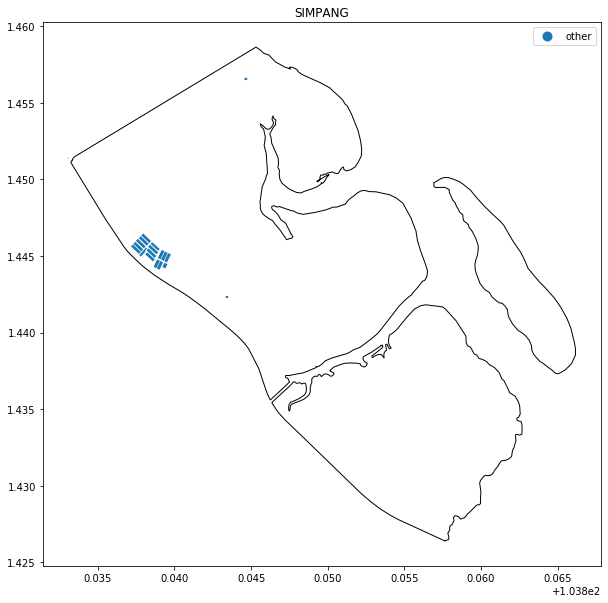

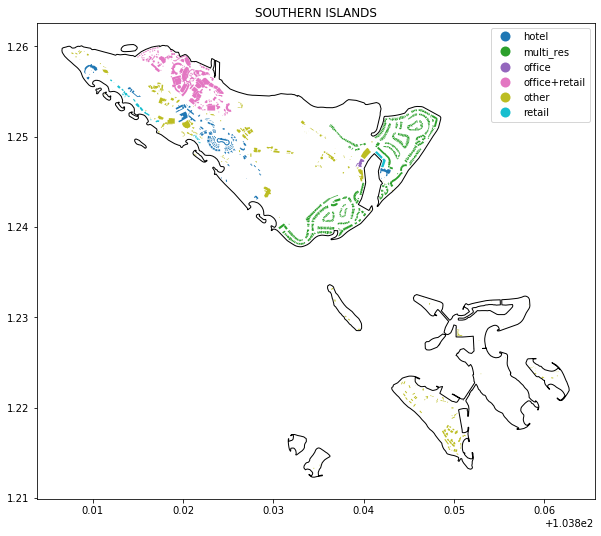

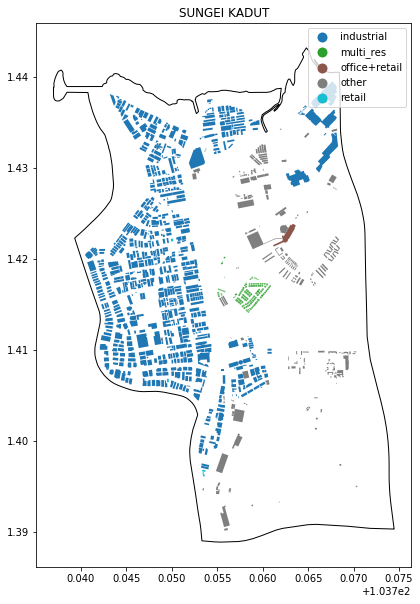

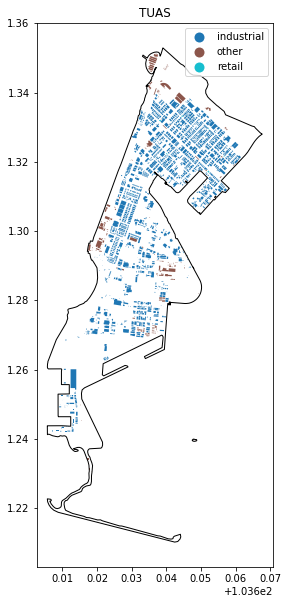

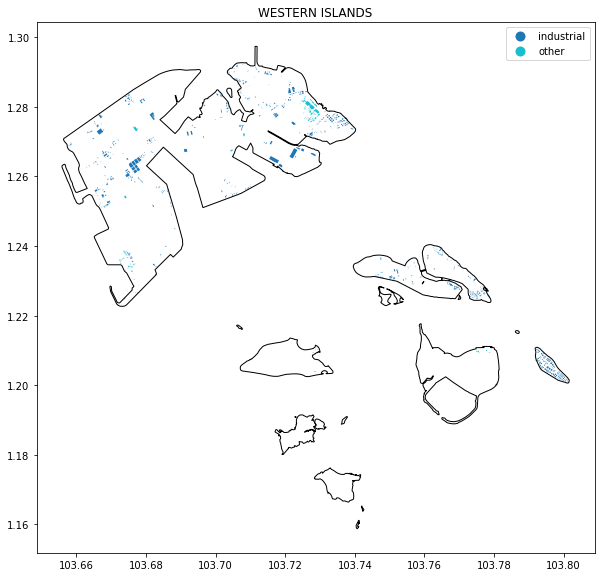

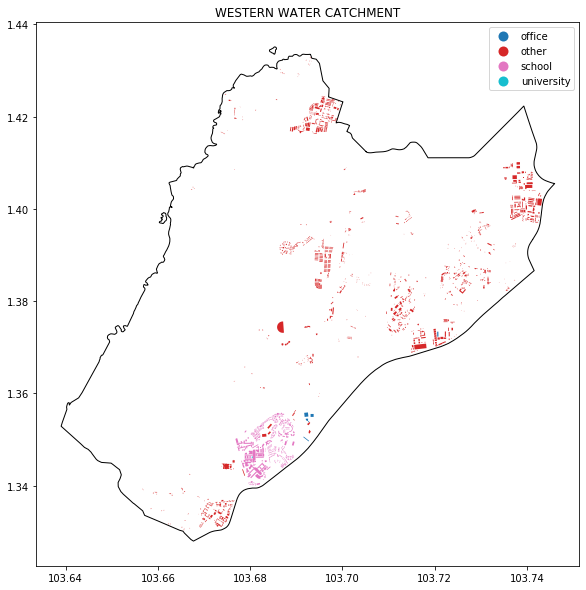

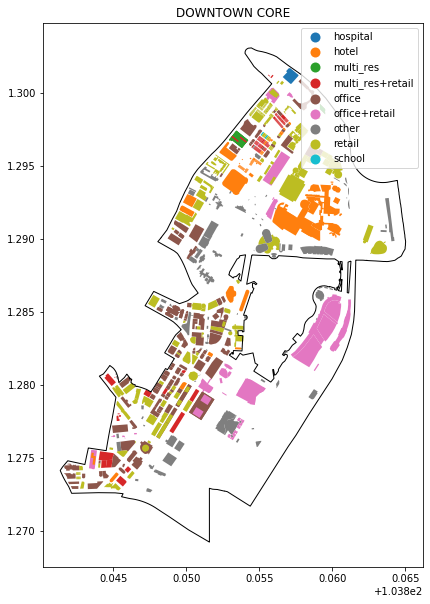

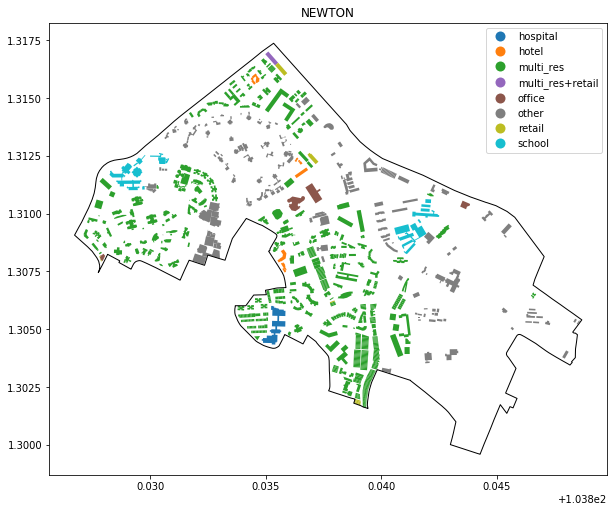

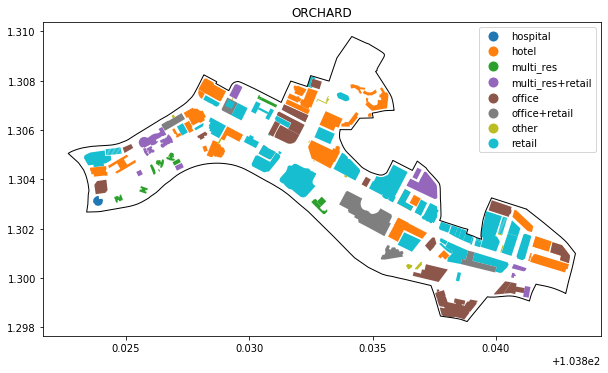

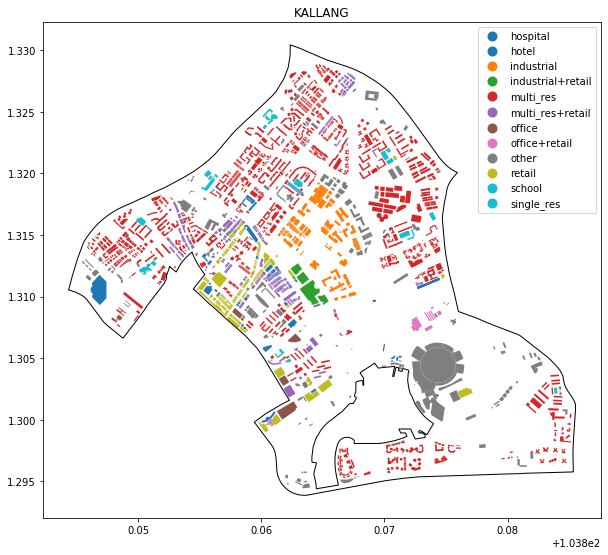

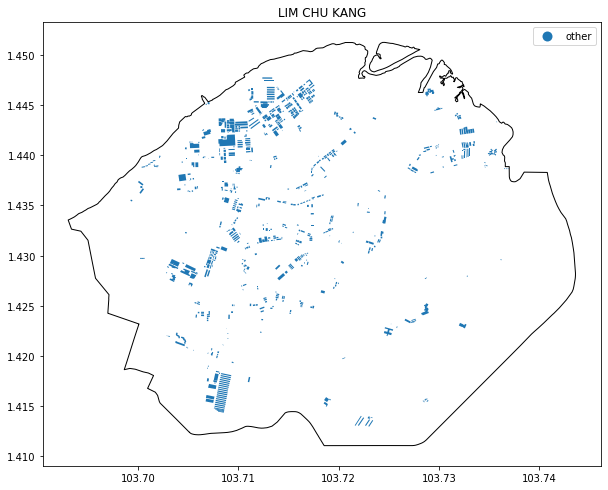

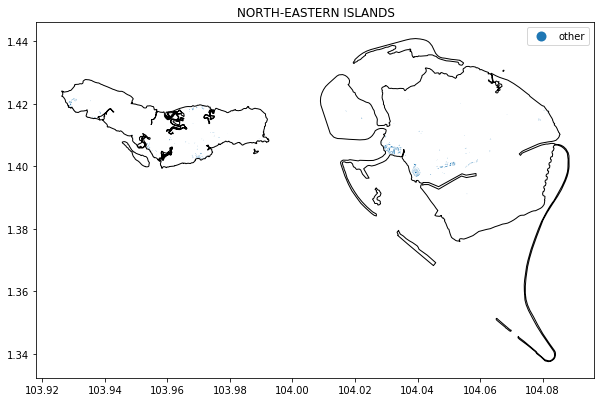

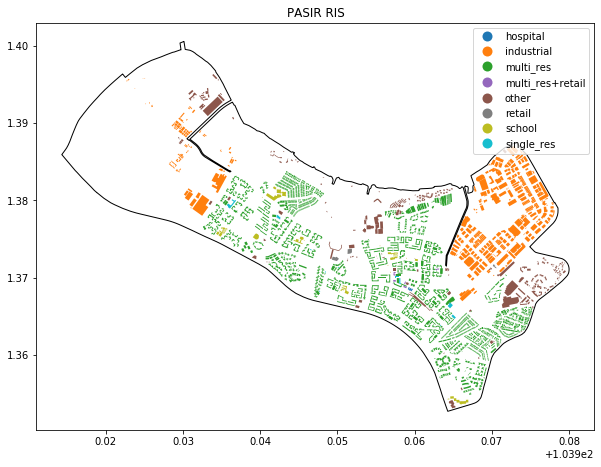

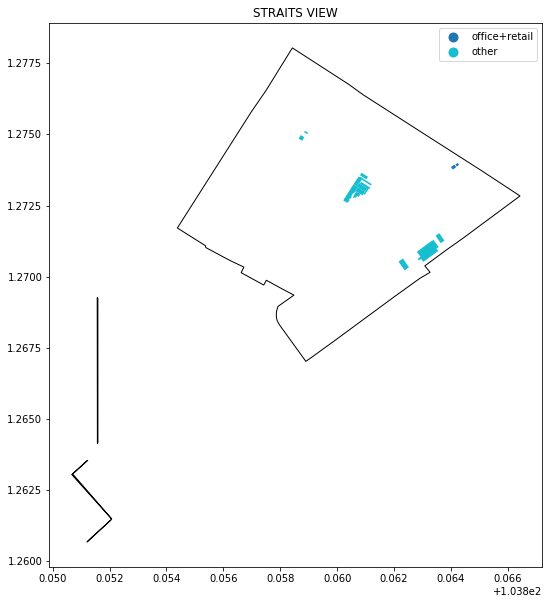

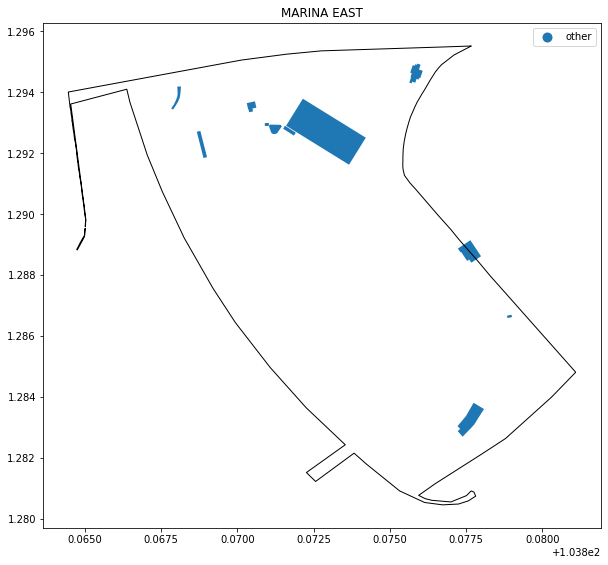

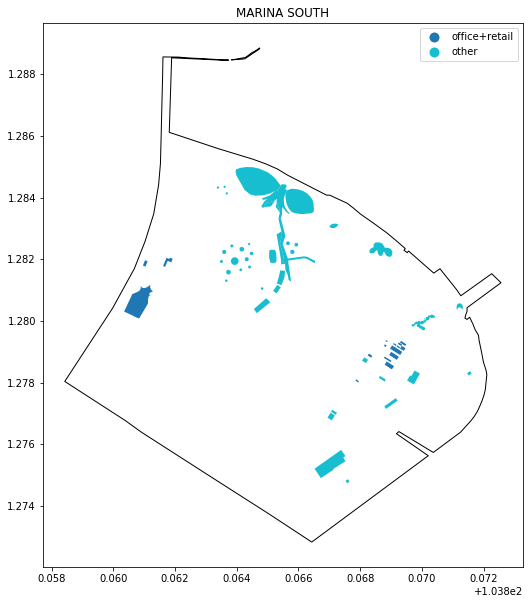

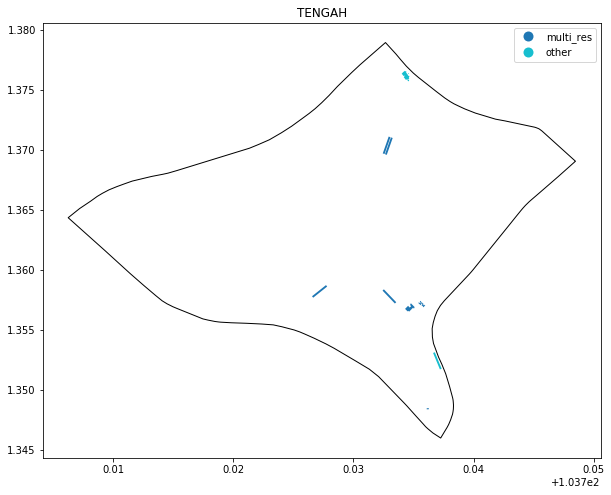

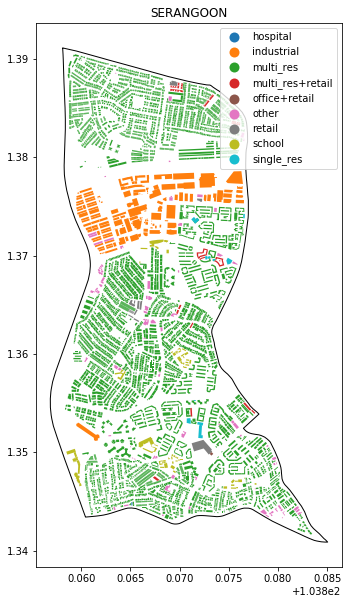

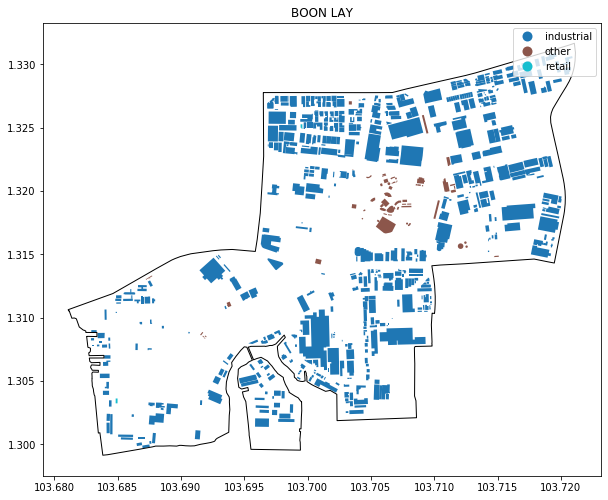

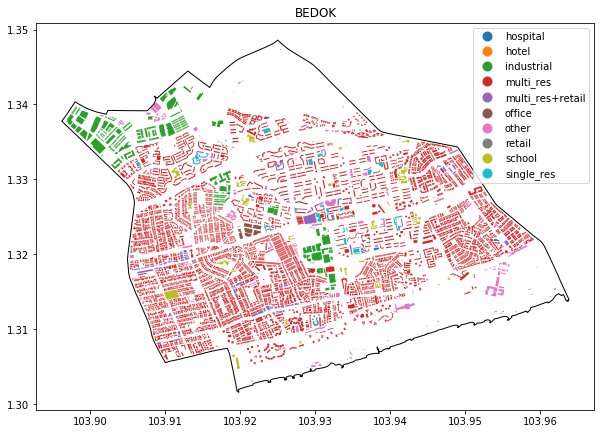

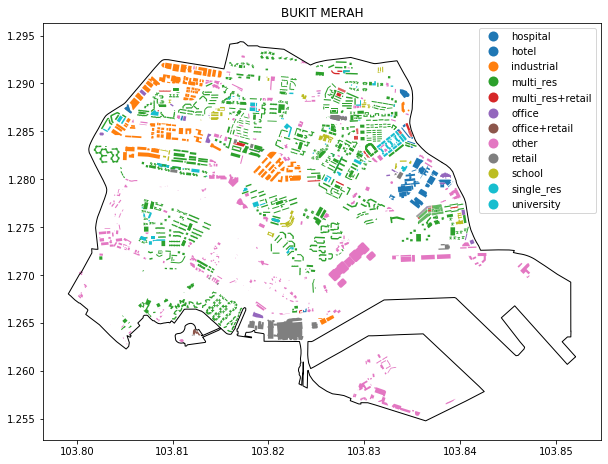

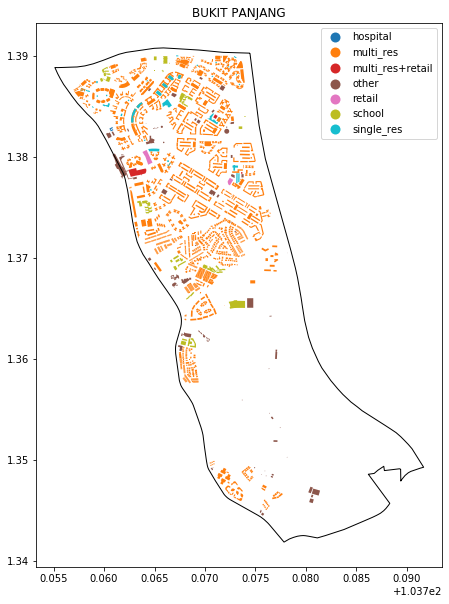

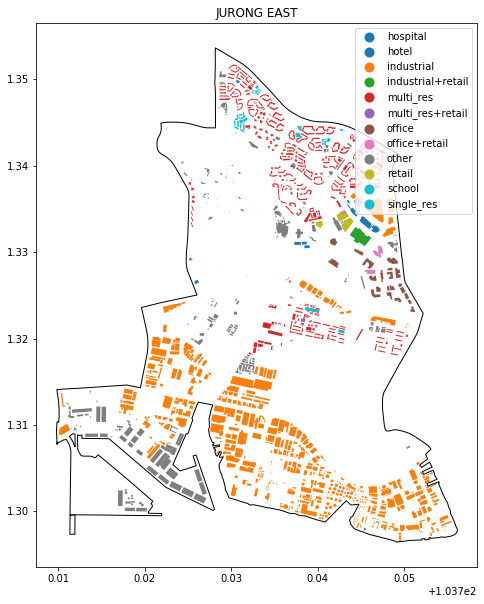

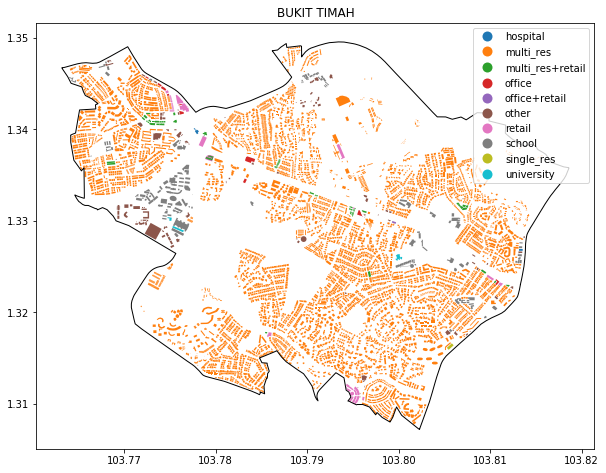

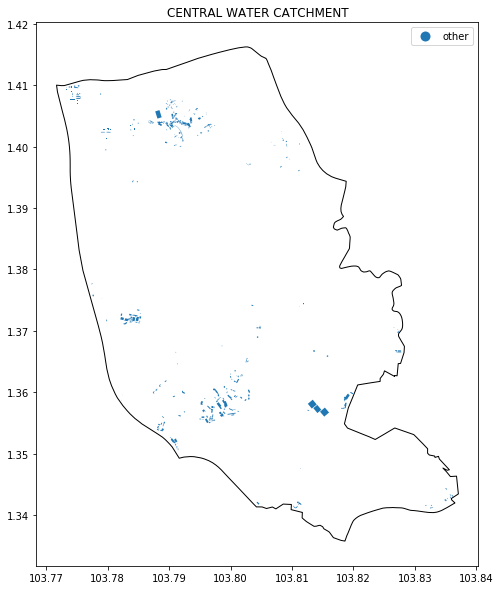

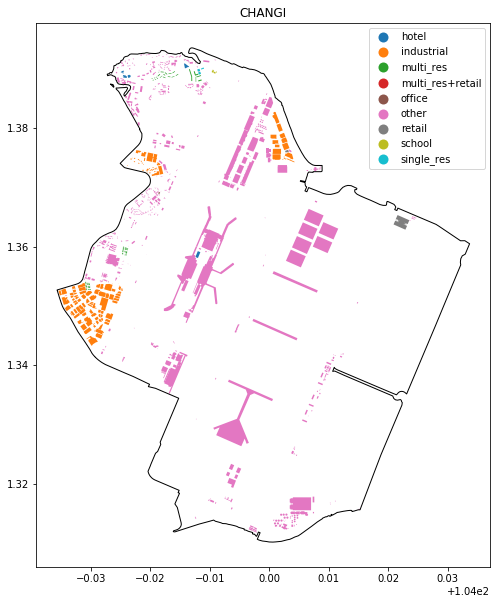

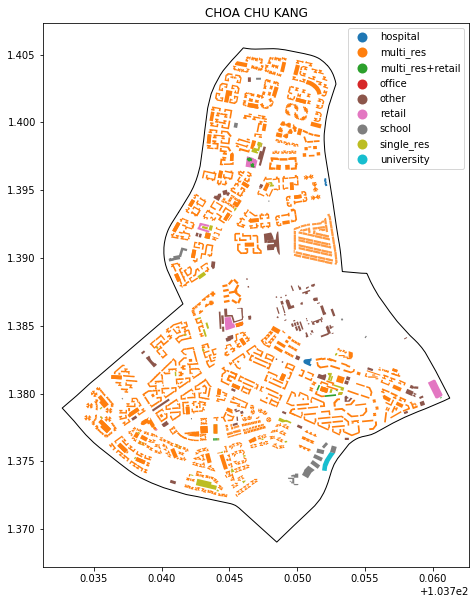

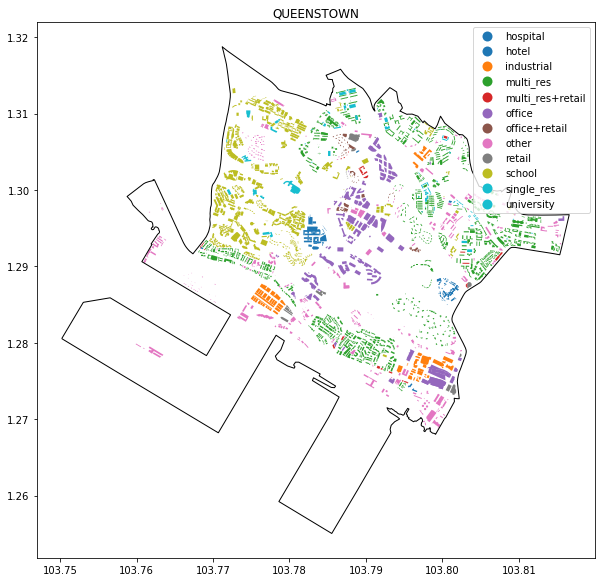

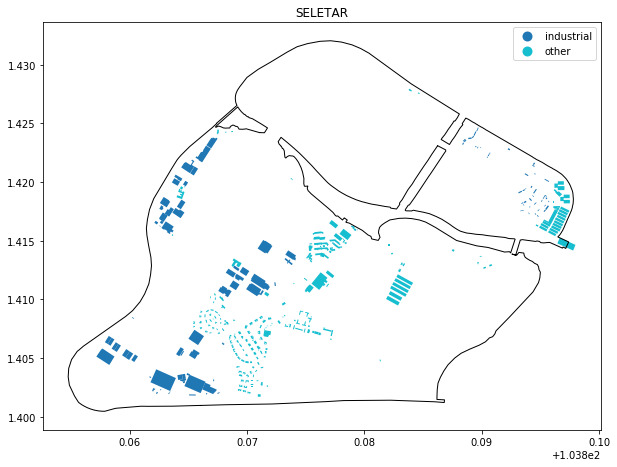

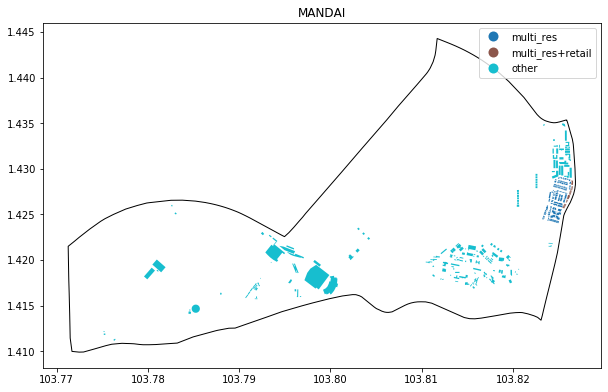

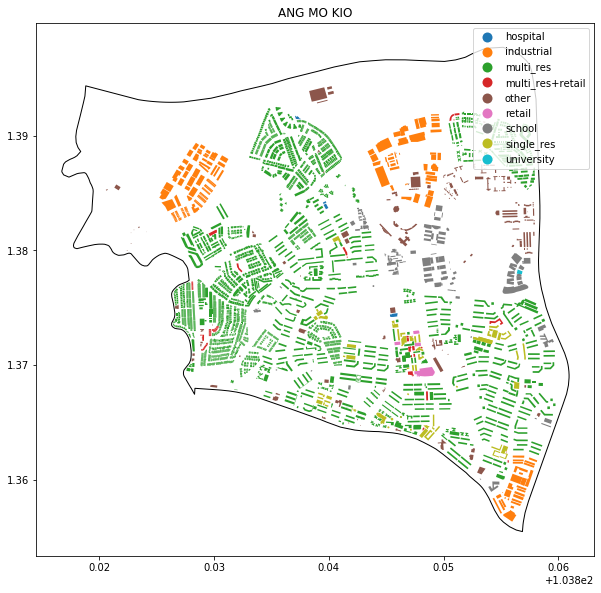

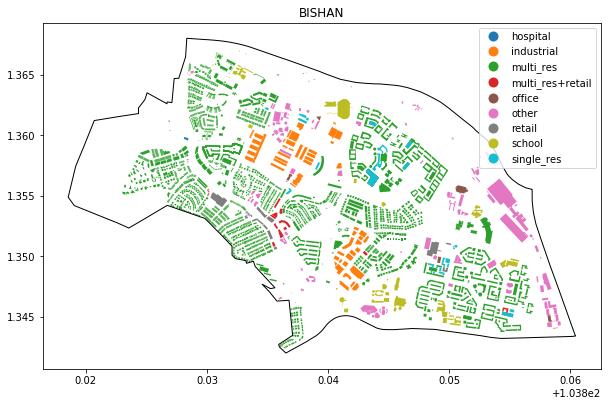

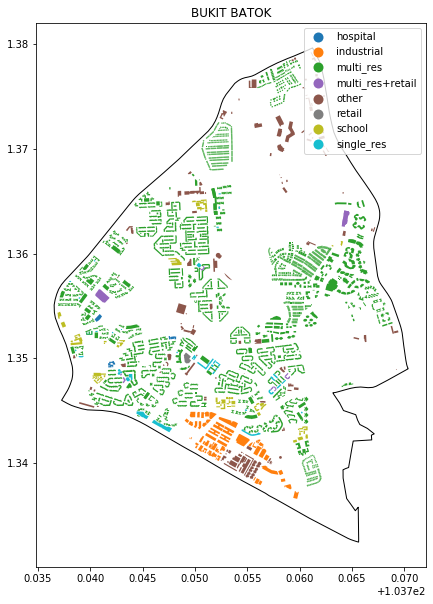

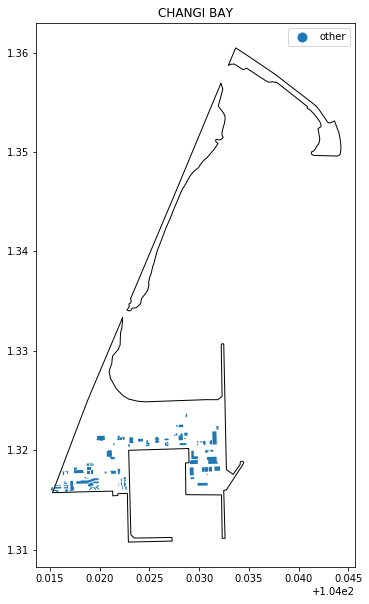

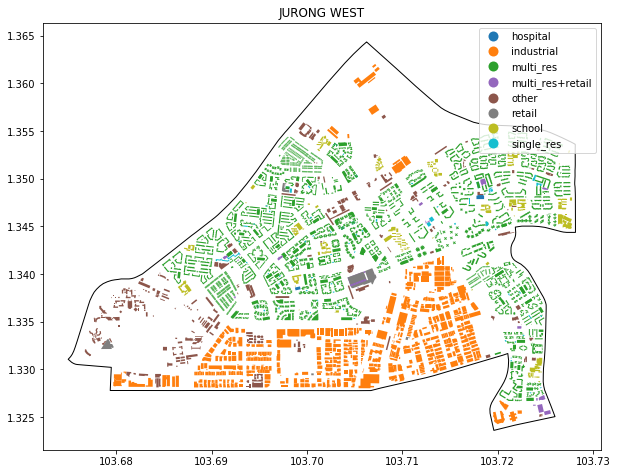

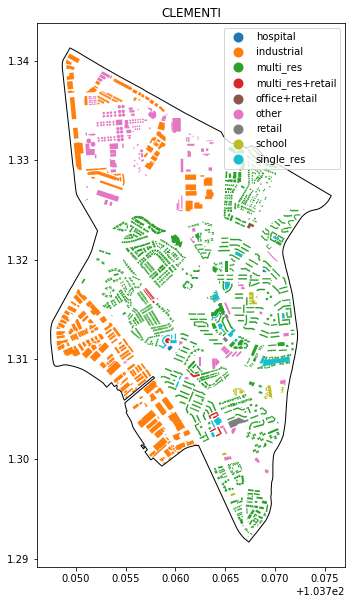

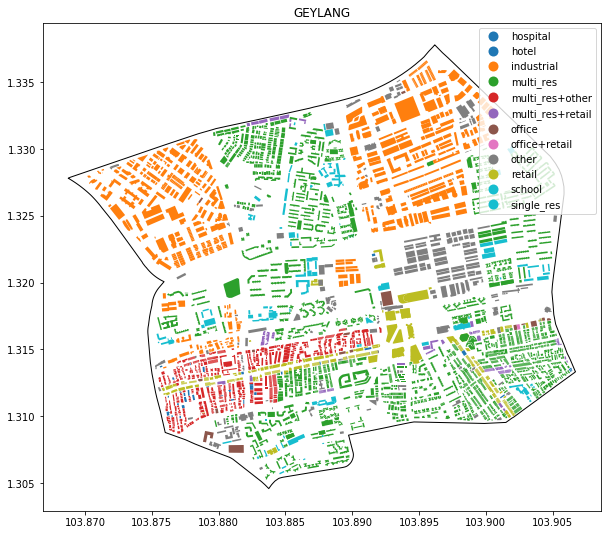

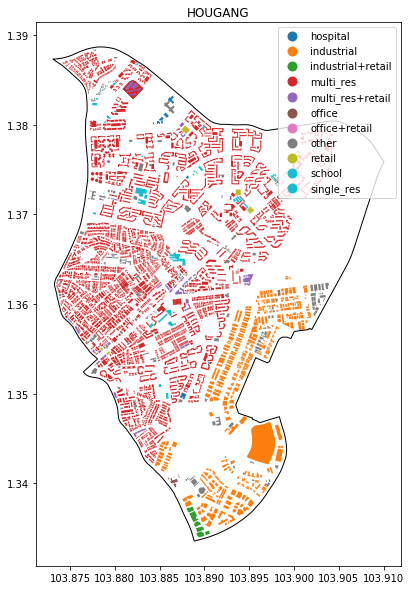

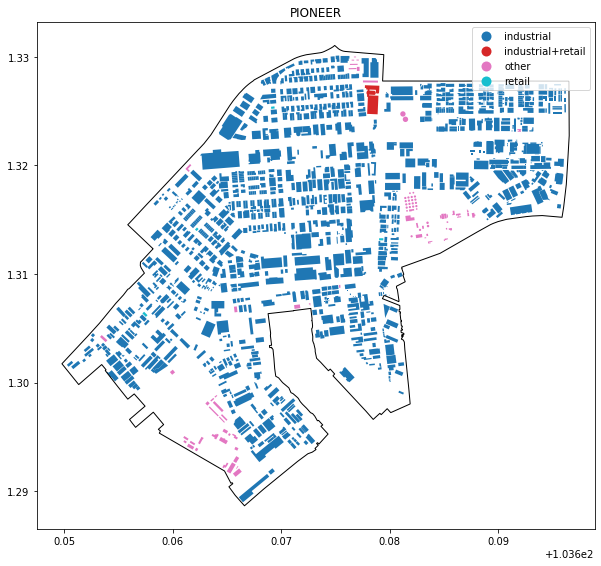

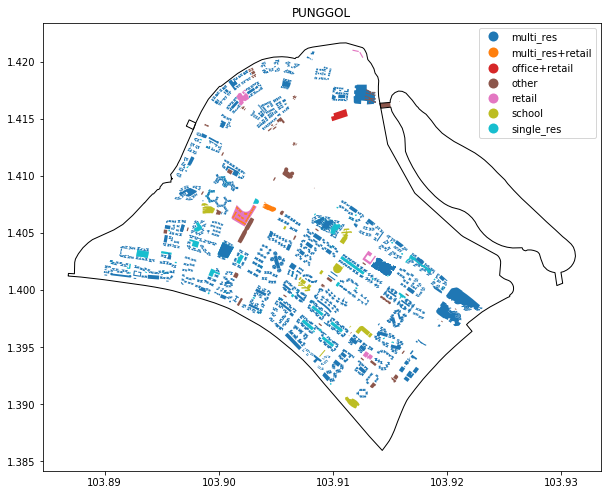

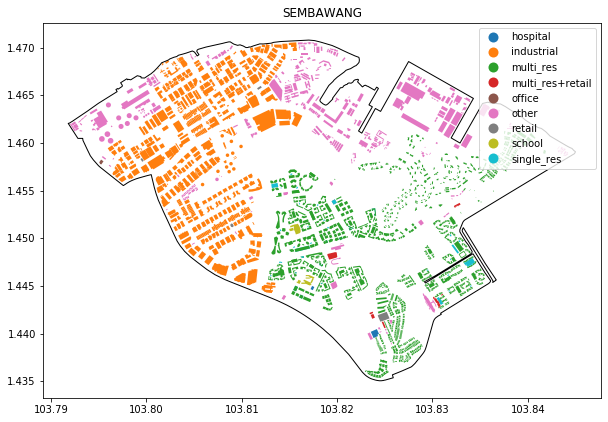

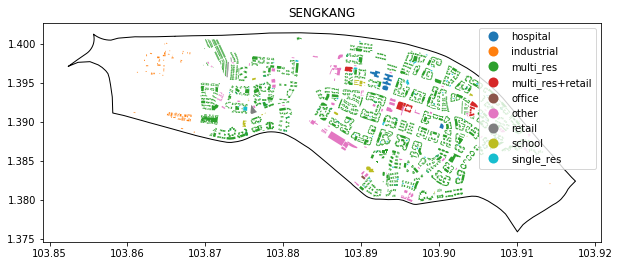

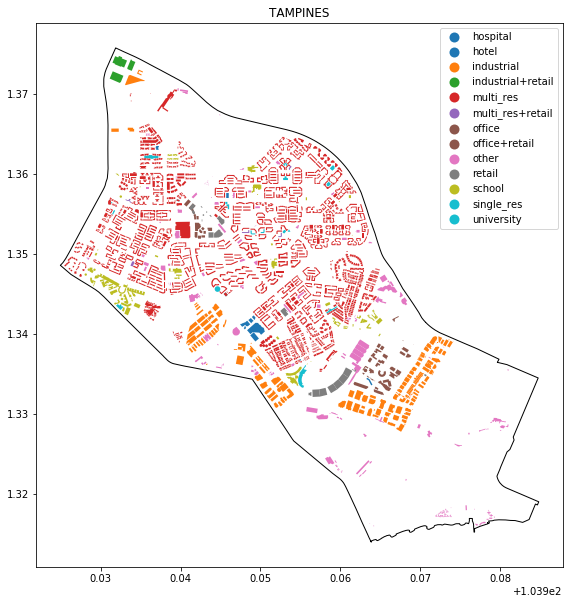

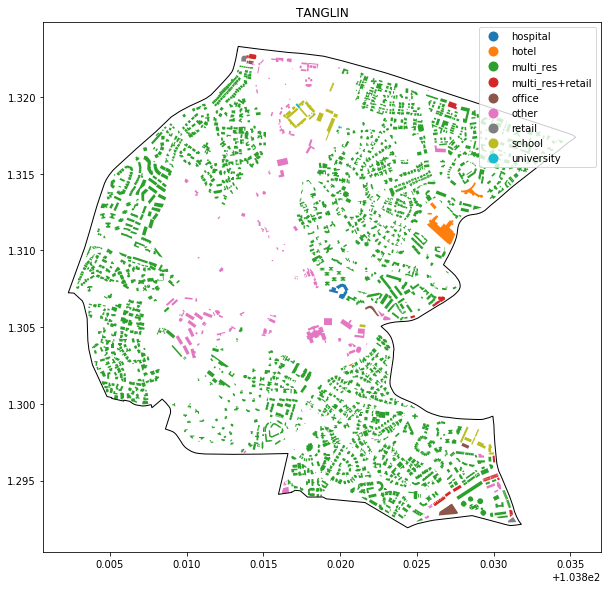

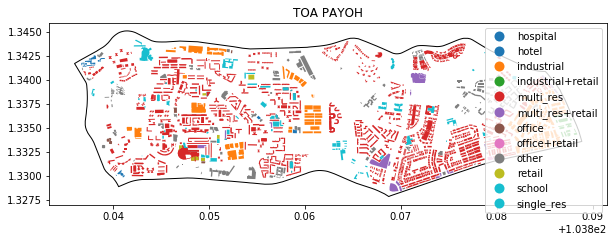

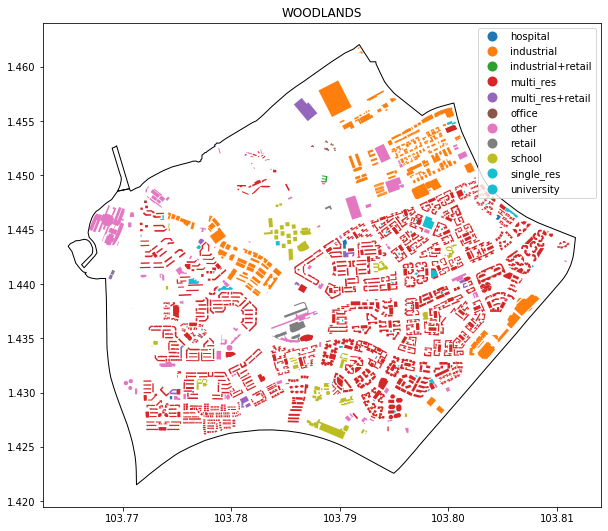

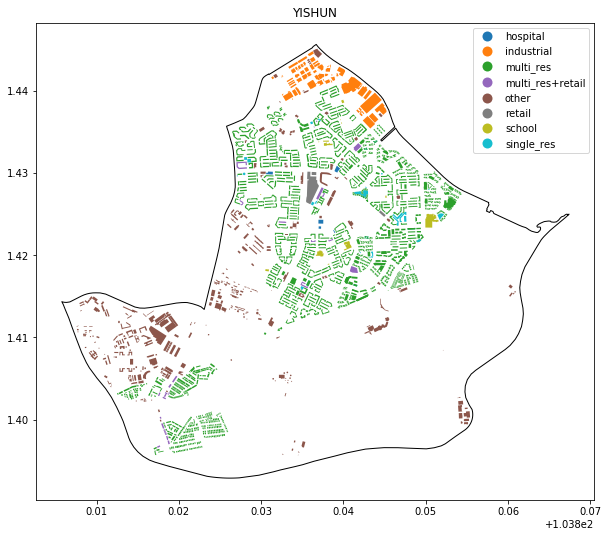

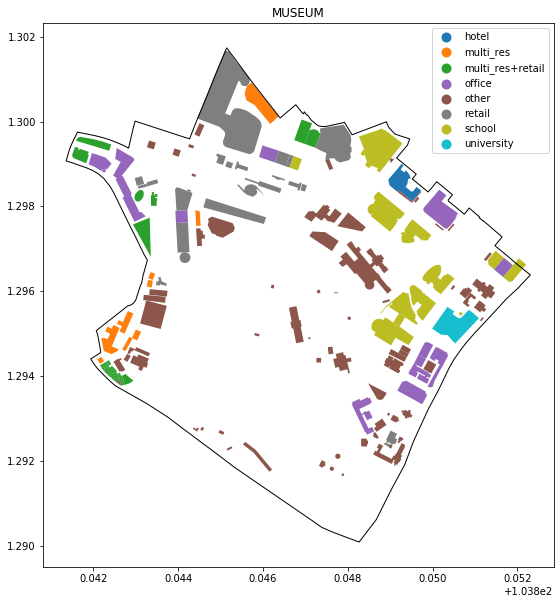

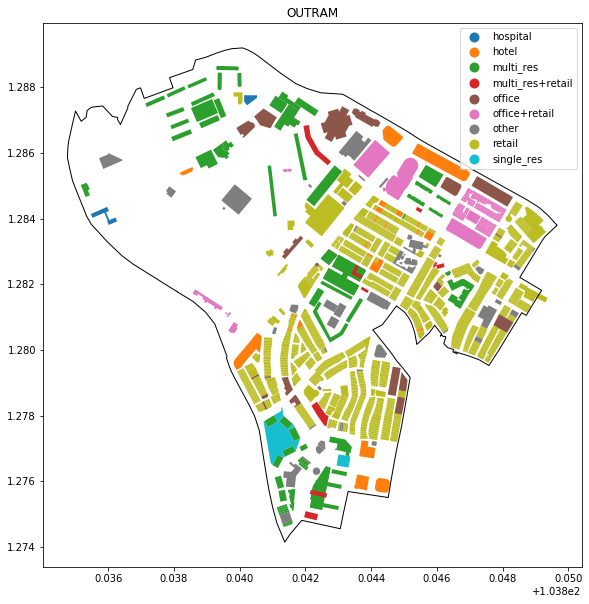

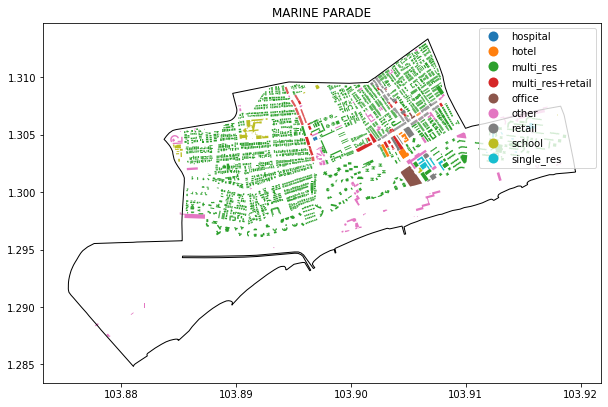

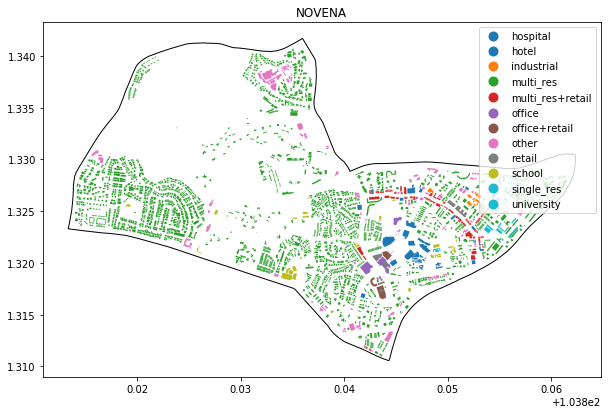

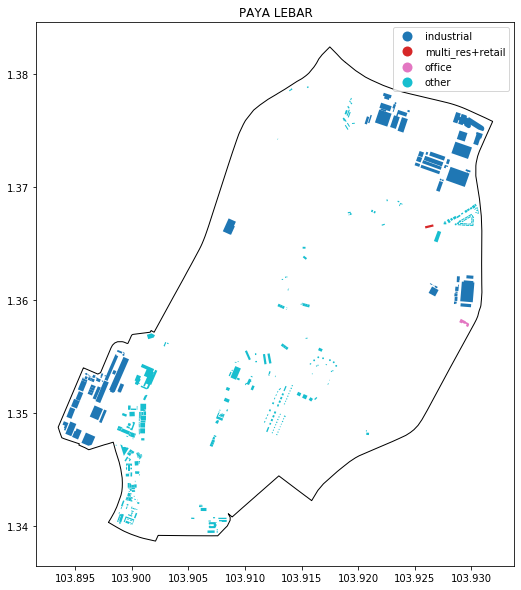

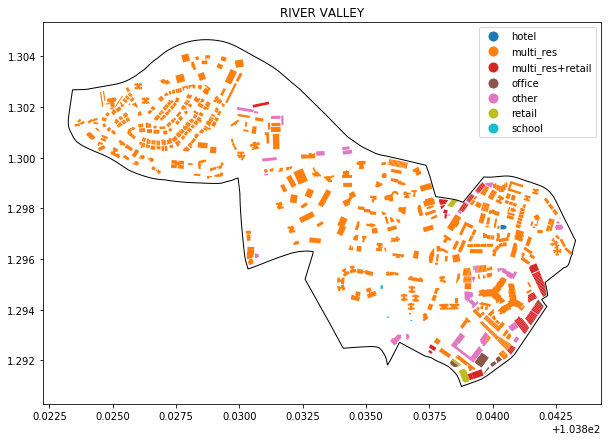

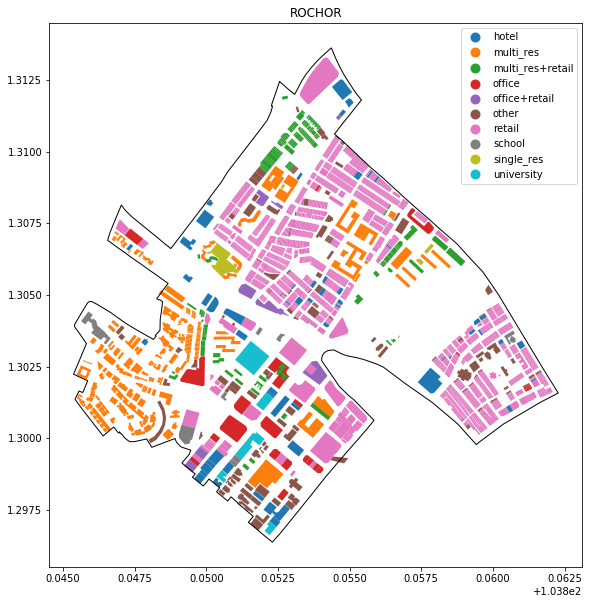

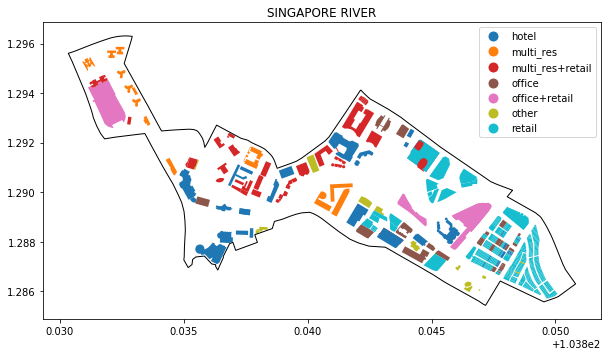

In [63]:
for area in planning_areas['planning_area_name'].unique():
    fig, ax = plt.subplots(figsize=(10,10))
    planning_area = planning_areas[planning_areas['planning_area_name'] == area]
    planning_area.boundary.plot(color=None, edgecolor='k',linewidth = 1, ax=ax)
    buildings[buildings['planning_area'] == area].plot(column='use', ax=ax, legend=True)
    
    ax.set_title(area)